In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import scipy
import scipy.stats
from scipy.stats import norm
import math
import random
import matplotlib.pyplot as plt
import pickle
from EM import EM
from plot import plot
from scipy import linalg
from numpy import ma

### Data Generation

In [128]:
class Model:
    # num_tseries is the number of time series generated by Model, each is time_length long
    # missing is the probability of an observation missing, default to zero 
    def __init__(self, time_length, num_tseries, missing=0):
        self.T = time_length
        self.num_tseries = num_tseries
        # model parameters
        self.A = np.array([[0]]) # the coefficients a_j's stored in a matrix
        self.b = np.array([10])
        self.num_treatments = self.A.shape[1]
        self.num_chronic = self.b.shape[0]
        # noise are the variance, not standard deviation
        # noise for transition should be larger than noise for observation
        self.noise_0 = 10
        self.noise_1 = 1
        self.noise_2 = .01
        self.init_z = 6
        self.missing = missing
        # simulated data
        self.z = np.zeros((self.num_tseries, self.T))
        self.y = np.zeros((self.num_tseries, self.T))
        self.X = np.zeros((self.num_tseries, self.T, self.num_treatments))
        self.c = np.zeros((self.num_tseries, self.num_chronic))
        self.pi = np.zeros((self.num_tseries, self.T))
        
    def set_X(self, n):
        for t in range(self.T):
            self.X[n, t, :] = np.random.binomial(n=1, p=0.0, size=self.A.shape[1])# np.random.randint(2, size = self.num_treatments)

    def set_c(self, n):
        self.c[n, :] = np.random.binomial(n=1, p=0.5, size=self.num_chronic)#np.random.randint(2, size = self.num_chronic)
        
    def transition(self, prev):
        z = np.random.normal(prev, np.sqrt(self.noise_1), 1)
        return z

    def emission(self, z, n, t):
        treatment_effect = 0
        for j in range(np.shape(self.A)[0]):
            if t-1 >= j:
                treatment_effect += np.dot(self.A[j, :], self.X[n, t-1-j, :])
        pi = treatment_effect + np.dot(self.b, self.c[n, :]) # total added effect
        prob = np.random.uniform(0, 1, 1)
        # to simulate time series we are dealing with, the first and last observations are not missing
        if prob < self.missing and t > 0 and t != self.T-1:
            y = np.nan
        else:
            mean = z + pi
            y = np.random.normal(mean, np.sqrt(self.noise_2), 1)
        return y, pi
    
    def pct_missing(self, n):
        pct = np.shape(np.where(np.isnan(self.y[n, :]))[0])[0]/self.T*100
        print('missing {}% of observations'.format(pct))
    
    # generate a single trajectory indexed n
    def gen_trajectory(self, n):
        self.set_X(n)
        self.set_c(n)
        self.z[n, 0] = np.random.normal(self.init_z, np.sqrt(self.noise_0), 1)
        self.y[n, 0], self.pi[n, 0] = self.emission(self.z[n, 0], n, 0)
        for t in range(1, self.T):
            self.z[n, t] = self.transition(self.z[n, t-1])
            self.y[n, t], self.pi[n, t] = self.emission(self.z[n, t], n, t)
    
    # plot the trajectory indexed n
    def plot_trajectory(self, n):
        times = list(range(self.T))
        fig = plt.figure()
        plt.plot(times, self.y[n, :], label = 'observed')
        plt.plot(times, self.z[n, :], label = 'counterfactual')
        for t in np.nonzero(self.X[n, :, :])[0]:
            plt.axvline(x=t, color='g', linestyle='--')
        plt.xlabel('time (hr)')
        plt.ylabel('INR')
        plt.title('Simulated trajectory')
        plt.legend()
        fig.set_figheight(8)
        fig.set_figwidth(15)
        plt.show()
    
    # generate and plot multiple trajectories 
    def run_simulation(self):
        np.random.seed(0)
        for n in range(self.num_tseries):
            self.gen_trajectory(n)
            #self.plot_trajectory(n)
            #self.pct_missing(n)

In [129]:
%%capture
model = Model(10, 50, 0.0)
model.run_simulation()

In [112]:
%%time
em = EM(model.y, model.X, model.c, model.A.shape[0], 0, train_pct = 1, single_effect=False, init_given=True, init_A=np.zeros_like(model.A), init_b=np.full_like(model.b, 9.0, dtype=np.float), init_0=.01, init_1=1, init_2=.01, init_state=6)#, X_prev_given=True, X_prev=X_prev)
num_iter = em.run_EM(10000)

iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
iteration 20
iteration 21
iteration 22
iteration 23
iteration 24
iteration 25
iteration 26
iteration 27
iteration 28
iteration 29
iteration 30
iteration 31
iteration 32
iteration 33
iteration 34
iteration 35
iteration 36
iteration 37
iteration 38
iteration 39
iteration 40
iteration 41
iteration 42
iteration 43
iteration 44
iteration 45
iteration 46
iteration 47
iteration 48
iteration 49
iteration 50
50 iterations before params converge
CPU times: user 2.65 s, sys: 20.2 ms, total: 2.67 s
Wall time: 2.64 s


In [113]:
print('initial state variance initialization: {}'.format(round(em.init_0, 5)))
print('chronic initialization: {}'.format(np.round(em.init_b, 5)))
print('estimated initial state variance: {}'.format(round(em.sigma_0, 5)))
print('estimated chronic: {}'.format(np.round(em.b, 5)))

initial state variance initialization: 0.01
chronic initialization: [9.]
estimated initial state variance: 4.92079
estimated chronic: [9.17377]


In [ ]:
%%time
initial_b = [-5, -3, 0, 3, 5, 7, 9, 11, 13, 15, 19]
initial_sigma_0 = [.1]
results = []
for sigma in initial_sigma_0:
    for b in initial_b:
        em = EM(model.y, model.X, model.c, model.A.shape[0], 0, train_pct = 1, single_effect=False, init_given=True, init_A=np.zeros_like(model.A), init_b=np.full_like(model.b, b, dtype=np.float), init_0=sigma, init_1=1, init_2=.01, init_state=6)#, X_prev_given=True, X_prev=X_prev)
        num_iter = em.run_EM(20000)
        results.append([em.init_0, em.init_b, em.sigma_0, em.b])

iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
iteration 20
iteration 21
iteration 22
iteration 23
iteration 24
iteration 25
iteration 26
iteration 27
iteration 28
iteration 29
iteration 30
iteration 31
iteration 32
iteration 33
iteration 34
iteration 35
iteration 36
iteration 37
iteration 38
iteration 39
iteration 40
iteration 41
iteration 42
iteration 43
iteration 44
iteration 45
iteration 46
iteration 47
iteration 48
iteration 49
iteration 50
iteration 51
iteration 52
iteration 53
iteration 54
iteration 55
iteration 56
iteration 57
iteration 58
iteration 59
iteration 60
iteration 61
iteration 62
iteration 63
iteration 64
iteration 65
iteration 66
iteration 67
iteration 68
iteration 69
iteration 70
iteration 71
iteration 72
iteration 73
iteration 74
iteration 75
iteration 76
iteration 77
iteratio

iteration 597
iteration 598
iteration 599
iteration 600
iteration 601
iteration 602
iteration 603
iteration 604
iteration 605
iteration 606
iteration 607
iteration 608
iteration 609
iteration 610
iteration 611
iteration 612
iteration 613
iteration 614
iteration 615
iteration 616
iteration 617
iteration 618
iteration 619
iteration 620
iteration 621
iteration 622
iteration 623
iteration 624
iteration 625
iteration 626
iteration 627
iteration 628
iteration 629
iteration 630
iteration 631
iteration 632
iteration 633
iteration 634
iteration 635
iteration 636
iteration 637
iteration 638
iteration 639
iteration 640
iteration 641
iteration 642
iteration 643
iteration 644
iteration 645
iteration 646
iteration 647
iteration 648
iteration 649
iteration 650
iteration 651
iteration 652
iteration 653
iteration 654
iteration 655
iteration 656
iteration 657
iteration 658
iteration 659
iteration 660
iteration 661
iteration 662
iteration 663
iteration 664
iteration 665
iteration 666
iteration 667
iterat

iteration 1171
iteration 1172
iteration 1173
iteration 1174
iteration 1175
iteration 1176
iteration 1177
iteration 1178
iteration 1179
iteration 1180
iteration 1181
iteration 1182
iteration 1183
iteration 1184
iteration 1185
iteration 1186
iteration 1187
iteration 1188
iteration 1189
iteration 1190
iteration 1191
iteration 1192
iteration 1193
iteration 1194
iteration 1195
iteration 1196
iteration 1197
iteration 1198
iteration 1199
iteration 1200
iteration 1201
iteration 1202
iteration 1203
iteration 1204
iteration 1205
iteration 1206
iteration 1207
iteration 1208
iteration 1209
iteration 1210
iteration 1211
iteration 1212
iteration 1213
iteration 1214
iteration 1215
iteration 1216
iteration 1217
iteration 1218
iteration 1219
iteration 1220
iteration 1221
iteration 1222
iteration 1223
iteration 1224
iteration 1225
iteration 1226
iteration 1227
iteration 1228
iteration 1229
iteration 1230
iteration 1231
iteration 1232
iteration 1233
iteration 1234
iteration 1235
iteration 1236
iteration 

iteration 1721
iteration 1722
iteration 1723
iteration 1724
iteration 1725
iteration 1726
iteration 1727
iteration 1728
iteration 1729
iteration 1730
iteration 1731
iteration 1732
iteration 1733
iteration 1734
iteration 1735
iteration 1736
iteration 1737
iteration 1738
iteration 1739
iteration 1740
iteration 1741
iteration 1742
iteration 1743
iteration 1744
iteration 1745
iteration 1746
iteration 1747
iteration 1748
iteration 1749
iteration 1750
iteration 1751
iteration 1752
iteration 1753
iteration 1754
iteration 1755
iteration 1756
iteration 1757
iteration 1758
iteration 1759
iteration 1760
iteration 1761
iteration 1762
iteration 1763
iteration 1764
iteration 1765
iteration 1766
iteration 1767
iteration 1768
iteration 1769
iteration 1770
iteration 1771
iteration 1772
iteration 1773
iteration 1774
iteration 1775
iteration 1776
iteration 1777
iteration 1778
iteration 1779
iteration 1780
iteration 1781
iteration 1782
iteration 1783
iteration 1784
iteration 1785
iteration 1786
iteration 

iteration 2271
iteration 2272
iteration 2273
iteration 2274
iteration 2275
iteration 2276
iteration 2277
iteration 2278
iteration 2279
iteration 2280
iteration 2281
iteration 2282
iteration 2283
iteration 2284
iteration 2285
iteration 2286
iteration 2287
iteration 2288
iteration 2289
iteration 2290
iteration 2291
iteration 2292
iteration 2293
iteration 2294
iteration 2295
iteration 2296
iteration 2297
iteration 2298
iteration 2299
iteration 2300
iteration 2301
iteration 2302
iteration 2303
iteration 2304
iteration 2305
iteration 2306
iteration 2307
iteration 2308
iteration 2309
iteration 2310
iteration 2311
iteration 2312
iteration 2313
iteration 2314
iteration 2315
iteration 2316
iteration 2317
iteration 2318
iteration 2319
iteration 2320
iteration 2321
iteration 2322
iteration 2323
iteration 2324
iteration 2325
iteration 2326
iteration 2327
iteration 2328
iteration 2329
iteration 2330
iteration 2331
iteration 2332
iteration 2333
iteration 2334
iteration 2335
iteration 2336
iteration 

iteration 2821
iteration 2822
iteration 2823
iteration 2824
iteration 2825
iteration 2826
iteration 2827
iteration 2828
iteration 2829
iteration 2830
iteration 2831
iteration 2832
iteration 2833
iteration 2834
iteration 2835
iteration 2836
iteration 2837
iteration 2838
iteration 2839
iteration 2840
iteration 2841
iteration 2842
iteration 2843
iteration 2844
iteration 2845
iteration 2846
iteration 2847
iteration 2848
iteration 2849
iteration 2850
iteration 2851
iteration 2852
iteration 2853
iteration 2854
iteration 2855
iteration 2856
iteration 2857
iteration 2858
iteration 2859
iteration 2860
iteration 2861
iteration 2862
iteration 2863
iteration 2864
iteration 2865
iteration 2866
iteration 2867
iteration 2868
iteration 2869
iteration 2870
iteration 2871
iteration 2872
iteration 2873
iteration 2874
iteration 2875
iteration 2876
iteration 2877
iteration 2878
iteration 2879
iteration 2880
iteration 2881
iteration 2882
iteration 2883
iteration 2884
iteration 2885
iteration 2886
iteration 

iteration 3371
iteration 3372
iteration 3373
iteration 3374
iteration 3375
iteration 3376
iteration 3377
iteration 3378
iteration 3379
iteration 3380
iteration 3381
iteration 3382
iteration 3383
iteration 3384
iteration 3385
iteration 3386
iteration 3387
iteration 3388
iteration 3389
iteration 3390
iteration 3391
iteration 3392
iteration 3393
iteration 3394
iteration 3395
iteration 3396
iteration 3397
iteration 3398
iteration 3399
iteration 3400
iteration 3401
iteration 3402
iteration 3403
iteration 3404
iteration 3405
iteration 3406
iteration 3407
iteration 3408
iteration 3409
iteration 3410
iteration 3411
iteration 3412
iteration 3413
iteration 3414
iteration 3415
iteration 3416
iteration 3417
iteration 3418
iteration 3419
iteration 3420
iteration 3421
iteration 3422
iteration 3423
iteration 3424
iteration 3425
iteration 3426
iteration 3427
iteration 3428
iteration 3429
iteration 3430
iteration 3431
iteration 3432
iteration 3433
iteration 3434
iteration 3435
iteration 3436
iteration 

iteration 3919
iteration 3920
iteration 3921
iteration 3922
iteration 3923
iteration 3924
iteration 3925
iteration 3926
iteration 3927
iteration 3928
iteration 3929
iteration 3930
iteration 3931
iteration 3932
iteration 3933
iteration 3934
iteration 3935
iteration 3936
iteration 3937
iteration 3938
iteration 3939
iteration 3940
iteration 3941
iteration 3942
iteration 3943
iteration 3944
iteration 3945
iteration 3946
iteration 3947
iteration 3948
iteration 3949
iteration 3950
iteration 3951
iteration 3952
iteration 3953
iteration 3954
iteration 3955
iteration 3956
iteration 3957
iteration 3958
iteration 3959
iteration 3960
iteration 3961
iteration 3962
iteration 3963
iteration 3964
iteration 3965
iteration 3966
iteration 3967
iteration 3968
iteration 3969
iteration 3970
iteration 3971
iteration 3972
iteration 3973
iteration 3974
iteration 3975
iteration 3976
iteration 3977
iteration 3978
iteration 3979
iteration 3980
iteration 3981
iteration 3982
iteration 3983
iteration 3984
iteration 

iteration 4467
iteration 4468
iteration 4469
iteration 4470
iteration 4471
iteration 4472
iteration 4473
iteration 4474
iteration 4475
iteration 4476
iteration 4477
iteration 4478
iteration 4479
iteration 4480
iteration 4481
iteration 4482
iteration 4483
iteration 4484
iteration 4485
iteration 4486
iteration 4487
iteration 4488
iteration 4489
iteration 4490
iteration 4491
iteration 4492
iteration 4493
iteration 4494
iteration 4495
iteration 4496
iteration 4497
iteration 4498
iteration 4499
iteration 4500
iteration 4501
iteration 4502
iteration 4503
iteration 4504
iteration 4505
iteration 4506
iteration 4507
iteration 4508
iteration 4509
iteration 4510
iteration 4511
iteration 4512
iteration 4513
iteration 4514
iteration 4515
iteration 4516
iteration 4517
iteration 4518
iteration 4519
iteration 4520
iteration 4521
iteration 4522
iteration 4523
iteration 4524
iteration 4525
iteration 4526
iteration 4527
iteration 4528
iteration 4529
iteration 4530
iteration 4531
iteration 4532
iteration 

iteration 5017
iteration 5018
iteration 5019
iteration 5020
iteration 5021
iteration 5022
iteration 5023
iteration 5024
iteration 5025
iteration 5026
iteration 5027
iteration 5028
iteration 5029
iteration 5030
iteration 5031
iteration 5032
iteration 5033
iteration 5034
iteration 5035
iteration 5036
iteration 5037
iteration 5038
iteration 5039
iteration 5040
iteration 5041
iteration 5042
iteration 5043
iteration 5044
iteration 5045
iteration 5046
iteration 5047
iteration 5048
iteration 5049
iteration 5050
iteration 5051
iteration 5052
iteration 5053
iteration 5054
iteration 5055
iteration 5056
iteration 5057
iteration 5058
iteration 5059
iteration 5060
iteration 5061
iteration 5062
iteration 5063
iteration 5064
iteration 5065
iteration 5066
iteration 5067
iteration 5068
iteration 5069
iteration 5070
iteration 5071
iteration 5072
iteration 5073
iteration 5074
iteration 5075
iteration 5076
iteration 5077
iteration 5078
iteration 5079
iteration 5080
iteration 5081
iteration 5082
iteration 

iteration 5566
iteration 5567
iteration 5568
iteration 5569
iteration 5570
iteration 5571
iteration 5572
iteration 5573
iteration 5574
iteration 5575
iteration 5576
iteration 5577
iteration 5578
iteration 5579
iteration 5580
iteration 5581
iteration 5582
iteration 5583
iteration 5584
iteration 5585
iteration 5586
iteration 5587
iteration 5588
iteration 5589
iteration 5590
iteration 5591
iteration 5592
iteration 5593
iteration 5594
iteration 5595
iteration 5596
iteration 5597
iteration 5598
iteration 5599
iteration 5600
iteration 5601
iteration 5602
iteration 5603
iteration 5604
iteration 5605
iteration 5606
iteration 5607
iteration 5608
iteration 5609
iteration 5610
iteration 5611
iteration 5612
iteration 5613
iteration 5614
iteration 5615
iteration 5616
iteration 5617
iteration 5618
iteration 5619
iteration 5620
iteration 5621
iteration 5622
iteration 5623
iteration 5624
iteration 5625
iteration 5626
iteration 5627
iteration 5628
iteration 5629
iteration 5630
iteration 5631
iteration 

iteration 6116
iteration 6117
iteration 6118
iteration 6119
iteration 6120
iteration 6121
iteration 6122
iteration 6123
iteration 6124
iteration 6125
iteration 6126
iteration 6127
iteration 6128
iteration 6129
iteration 6130
iteration 6131
iteration 6132
iteration 6133
iteration 6134
iteration 6135
iteration 6136
iteration 6137
iteration 6138
iteration 6139
iteration 6140
iteration 6141
iteration 6142
iteration 6143
iteration 6144
iteration 6145
iteration 6146
iteration 6147
iteration 6148
iteration 6149
iteration 6150
iteration 6151
iteration 6152
iteration 6153
iteration 6154
iteration 6155
iteration 6156
iteration 6157
iteration 6158
iteration 6159
iteration 6160
iteration 6161
iteration 6162
iteration 6163
iteration 6164
iteration 6165
iteration 6166
iteration 6167
iteration 6168
iteration 6169
iteration 6170
iteration 6171
iteration 6172
iteration 6173
iteration 6174
iteration 6175
iteration 6176
iteration 6177
iteration 6178
iteration 6179
iteration 6180
iteration 6181
iteration 

iteration 6666
iteration 6667
iteration 6668
iteration 6669
iteration 6670
iteration 6671
iteration 6672
iteration 6673
iteration 6674
iteration 6675
iteration 6676
iteration 6677
iteration 6678
iteration 6679
iteration 6680
iteration 6681
iteration 6682
iteration 6683
iteration 6684
iteration 6685
iteration 6686
iteration 6687
iteration 6688
iteration 6689
iteration 6690
iteration 6691
iteration 6692
iteration 6693
iteration 6694
iteration 6695
iteration 6696
iteration 6697
iteration 6698
iteration 6699
iteration 6700
iteration 6701
iteration 6702
iteration 6703
iteration 6704
iteration 6705
iteration 6706
iteration 6707
iteration 6708
iteration 6709
iteration 6710
iteration 6711
iteration 6712
iteration 6713
iteration 6714
iteration 6715
iteration 6716
iteration 6717
iteration 6718
iteration 6719
iteration 6720
iteration 6721
iteration 6722
iteration 6723
iteration 6724
iteration 6725
iteration 6726
iteration 6727
iteration 6728
iteration 6729
iteration 6730
iteration 6731
iteration 

iteration 7213
iteration 7214
iteration 7215
iteration 7216
iteration 7217
iteration 7218
iteration 7219
iteration 7220
iteration 7221
iteration 7222
iteration 7223
iteration 7224
iteration 7225
iteration 7226
iteration 7227
iteration 7228
iteration 7229
iteration 7230
iteration 7231
iteration 7232
iteration 7233
iteration 7234
iteration 7235
iteration 7236
iteration 7237
iteration 7238
iteration 7239
iteration 7240
iteration 7241
iteration 7242
iteration 7243
iteration 7244
iteration 7245
iteration 7246
iteration 7247
iteration 7248
iteration 7249
iteration 7250
iteration 7251
iteration 7252
iteration 7253
iteration 7254
iteration 7255
iteration 7256
iteration 7257
iteration 7258
iteration 7259
iteration 7260
iteration 7261
iteration 7262
iteration 7263
iteration 7264
iteration 7265
iteration 7266
iteration 7267
iteration 7268
iteration 7269
iteration 7270
iteration 7271
iteration 7272
iteration 7273
iteration 7274
iteration 7275
iteration 7276
iteration 7277
iteration 7278
iteration 

iteration 7762
iteration 7763
iteration 7764
iteration 7765
iteration 7766
iteration 7767
iteration 7768
iteration 7769
iteration 7770
iteration 7771
iteration 7772
iteration 7773
iteration 7774
iteration 7775
iteration 7776
iteration 7777
iteration 7778
iteration 7779
iteration 7780
iteration 7781
iteration 7782
iteration 7783
iteration 7784
iteration 7785
iteration 7786
iteration 7787
iteration 7788
iteration 7789
iteration 7790
iteration 7791
iteration 7792
iteration 7793
iteration 7794
iteration 7795
iteration 7796
iteration 7797
iteration 7798
iteration 7799
iteration 7800
iteration 7801
iteration 7802
iteration 7803
iteration 7804
iteration 7805
iteration 7806
iteration 7807
iteration 7808
iteration 7809
iteration 7810
iteration 7811
iteration 7812
iteration 7813
iteration 7814
iteration 7815
iteration 7816
iteration 7817
iteration 7818
iteration 7819
iteration 7820
iteration 7821
iteration 7822
iteration 7823
iteration 7824
iteration 7825
iteration 7826
iteration 7827
iteration 

iteration 8311
iteration 8312
iteration 8313
iteration 8314
iteration 8315
iteration 8316
iteration 8317
iteration 8318
iteration 8319
iteration 8320
iteration 8321
iteration 8322
iteration 8323
iteration 8324
iteration 8325
iteration 8326
iteration 8327
iteration 8328
iteration 8329
iteration 8330
iteration 8331
iteration 8332
iteration 8333
iteration 8334
iteration 8335
iteration 8336
iteration 8337
iteration 8338
iteration 8339
iteration 8340
iteration 8341
iteration 8342
iteration 8343
iteration 8344
iteration 8345
iteration 8346
iteration 8347
iteration 8348
iteration 8349
iteration 8350
iteration 8351
iteration 8352
iteration 8353
iteration 8354
iteration 8355
iteration 8356
iteration 8357
iteration 8358
iteration 8359
iteration 8360
iteration 8361
iteration 8362
iteration 8363
iteration 8364
iteration 8365
iteration 8366
iteration 8367
iteration 8368
iteration 8369
iteration 8370
iteration 8371
iteration 8372
iteration 8373
iteration 8374
iteration 8375
iteration 8376
iteration 

iteration 8858
iteration 8859
iteration 8860
iteration 8861
iteration 8862
iteration 8863
iteration 8864
iteration 8865
iteration 8866
iteration 8867
iteration 8868
iteration 8869
iteration 8870
iteration 8871
iteration 8872
iteration 8873
iteration 8874
iteration 8875
iteration 8876
iteration 8877
iteration 8878
iteration 8879
iteration 8880
iteration 8881
iteration 8882
iteration 8883
iteration 8884
iteration 8885
iteration 8886
iteration 8887
iteration 8888
iteration 8889
iteration 8890
iteration 8891
iteration 8892
iteration 8893
iteration 8894
iteration 8895
iteration 8896
iteration 8897
iteration 8898
iteration 8899
iteration 8900
iteration 8901
iteration 8902
iteration 8903
iteration 8904
iteration 8905
iteration 8906
iteration 8907
iteration 8908
iteration 8909
iteration 8910
iteration 8911
iteration 8912
iteration 8913
iteration 8914
iteration 8915
iteration 8916
iteration 8917
iteration 8918
iteration 8919
iteration 8920
iteration 8921
iteration 8922
iteration 8923
iteration 

iteration 9406
iteration 9407
iteration 9408
iteration 9409
iteration 9410
iteration 9411
iteration 9412
iteration 9413
iteration 9414
iteration 9415
iteration 9416
iteration 9417
iteration 9418
iteration 9419
iteration 9420
iteration 9421
iteration 9422
iteration 9423
iteration 9424
iteration 9425
iteration 9426
iteration 9427
iteration 9428
iteration 9429
iteration 9430
iteration 9431
iteration 9432
iteration 9433
iteration 9434
iteration 9435
iteration 9436
iteration 9437
iteration 9438
iteration 9439
iteration 9440
iteration 9441
iteration 9442
iteration 9443
iteration 9444
iteration 9445
iteration 9446
iteration 9447
iteration 9448
iteration 9449
iteration 9450
iteration 9451
iteration 9452
iteration 9453
iteration 9454
iteration 9455
iteration 9456
iteration 9457
iteration 9458
iteration 9459
iteration 9460
iteration 9461
iteration 9462
iteration 9463
iteration 9464
iteration 9465
iteration 9466
iteration 9467
iteration 9468
iteration 9469
iteration 9470
iteration 9471
iteration 

iteration 9954
iteration 9955
iteration 9956
iteration 9957
iteration 9958
iteration 9959
iteration 9960
iteration 9961
iteration 9962
iteration 9963
iteration 9964
iteration 9965
iteration 9966
iteration 9967
iteration 9968
iteration 9969
iteration 9970
iteration 9971
iteration 9972
iteration 9973
iteration 9974
iteration 9975
iteration 9976
iteration 9977
iteration 9978
iteration 9979
iteration 9980
iteration 9981
iteration 9982
iteration 9983
iteration 9984
iteration 9985
iteration 9986
iteration 9987
iteration 9988
iteration 9989
iteration 9990
iteration 9991
iteration 9992
iteration 9993
iteration 9994
iteration 9995
iteration 9996
iteration 9997
iteration 9998
iteration 9999
iteration 10000
iteration 10001
iteration 10002
iteration 10003
iteration 10004
iteration 10005
iteration 10006
iteration 10007
iteration 10008
iteration 10009
iteration 10010
iteration 10011
iteration 10012
iteration 10013
iteration 10014
iteration 10015
iteration 10016
iteration 10017
iteration 10018
iterat

iteration 10471
iteration 10472
iteration 10473
iteration 10474
iteration 10475
iteration 10476
iteration 10477
iteration 10478
iteration 10479
iteration 10480
iteration 10481
iteration 10482
iteration 10483
iteration 10484
iteration 10485
iteration 10486
iteration 10487
iteration 10488
iteration 10489
iteration 10490
iteration 10491
iteration 10492
iteration 10493
iteration 10494
iteration 10495
iteration 10496
iteration 10497
iteration 10498
iteration 10499
iteration 10500
iteration 10501
iteration 10502
iteration 10503
iteration 10504
iteration 10505
iteration 10506
iteration 10507
iteration 10508
iteration 10509
iteration 10510
iteration 10511
iteration 10512
iteration 10513
iteration 10514
iteration 10515
iteration 10516
iteration 10517
iteration 10518
iteration 10519
iteration 10520
iteration 10521
iteration 10522
iteration 10523
iteration 10524
iteration 10525
iteration 10526
iteration 10527
iteration 10528
iteration 10529
iteration 10530
iteration 10531
iteration 10532
iteratio

iteration 10987
iteration 10988
iteration 10989
iteration 10990
iteration 10991
iteration 10992
iteration 10993
iteration 10994
iteration 10995
iteration 10996
iteration 10997
iteration 10998
iteration 10999
iteration 11000
iteration 11001
iteration 11002
iteration 11003
iteration 11004
iteration 11005
iteration 11006
iteration 11007
iteration 11008
iteration 11009
iteration 11010
iteration 11011
iteration 11012
iteration 11013
iteration 11014
iteration 11015
iteration 11016
iteration 11017
iteration 11018
iteration 11019
iteration 11020
iteration 11021
iteration 11022
iteration 11023
iteration 11024
iteration 11025
iteration 11026
iteration 11027
iteration 11028
iteration 11029
iteration 11030
iteration 11031
iteration 11032
iteration 11033
iteration 11034
iteration 11035
iteration 11036
iteration 11037
iteration 11038
iteration 11039
iteration 11040
iteration 11041
iteration 11042
iteration 11043
iteration 11044
iteration 11045
iteration 11046
iteration 11047
iteration 11048
iteratio

iteration 11501
iteration 11502
iteration 11503
iteration 11504
iteration 11505
iteration 11506
iteration 11507
iteration 11508
iteration 11509
iteration 11510
iteration 11511
iteration 11512
iteration 11513
iteration 11514
iteration 11515
iteration 11516
iteration 11517
iteration 11518
iteration 11519
iteration 11520
iteration 11521
iteration 11522
iteration 11523
iteration 11524
iteration 11525
iteration 11526
iteration 11527
iteration 11528
iteration 11529
iteration 11530
iteration 11531
iteration 11532
iteration 11533
iteration 11534
iteration 11535
iteration 11536
iteration 11537
iteration 11538
iteration 11539
iteration 11540
iteration 11541
iteration 11542
iteration 11543
iteration 11544
iteration 11545
iteration 11546
iteration 11547
iteration 11548
iteration 11549
iteration 11550
iteration 11551
iteration 11552
iteration 11553
iteration 11554
iteration 11555
iteration 11556
iteration 11557
iteration 11558
iteration 11559
iteration 11560
iteration 11561
iteration 11562
iteratio

iteration 12016
iteration 12017
iteration 12018
iteration 12019
iteration 12020
iteration 12021
iteration 12022
iteration 12023
iteration 12024
iteration 12025
iteration 12026
iteration 12027
iteration 12028
iteration 12029
iteration 12030
iteration 12031
iteration 12032
iteration 12033
iteration 12034
iteration 12035
iteration 12036
iteration 12037
iteration 12038
iteration 12039
iteration 12040
iteration 12041
iteration 12042
iteration 12043
iteration 12044
iteration 12045
iteration 12046
iteration 12047
iteration 12048
iteration 12049
iteration 12050
iteration 12051
iteration 12052
iteration 12053
iteration 12054
iteration 12055
iteration 12056
iteration 12057
iteration 12058
iteration 12059
iteration 12060
iteration 12061
iteration 12062
iteration 12063
iteration 12064
iteration 12065
iteration 12066
iteration 12067
iteration 12068
iteration 12069
iteration 12070
iteration 12071
iteration 12072
iteration 12073
iteration 12074
iteration 12075
iteration 12076
iteration 12077
iteratio

iteration 12532
iteration 12533
iteration 12534
iteration 12535
iteration 12536
iteration 12537
iteration 12538
iteration 12539
iteration 12540
iteration 12541
iteration 12542
iteration 12543
iteration 12544
iteration 12545
iteration 12546
iteration 12547
iteration 12548
iteration 12549
iteration 12550
iteration 12551
iteration 12552
iteration 12553
iteration 12554
iteration 12555
iteration 12556
iteration 12557
iteration 12558
iteration 12559
iteration 12560
iteration 12561
iteration 12562
iteration 12563
iteration 12564
iteration 12565
iteration 12566
iteration 12567
iteration 12568
iteration 12569
iteration 12570
iteration 12571
iteration 12572
iteration 12573
iteration 12574
iteration 12575
iteration 12576
iteration 12577
iteration 12578
iteration 12579
iteration 12580
iteration 12581
iteration 12582
iteration 12583
iteration 12584
iteration 12585
iteration 12586
iteration 12587
iteration 12588
iteration 12589
iteration 12590
iteration 12591
iteration 12592
iteration 12593
iteratio

iteration 13045
iteration 13046
iteration 13047
iteration 13048
iteration 13049
iteration 13050
iteration 13051
iteration 13052
iteration 13053
iteration 13054
iteration 13055
iteration 13056
iteration 13057
iteration 13058
iteration 13059
iteration 13060
iteration 13061
iteration 13062
iteration 13063
iteration 13064
iteration 13065
iteration 13066
iteration 13067
iteration 13068
iteration 13069
iteration 13070
iteration 13071
iteration 13072
iteration 13073
iteration 13074
iteration 13075
iteration 13076
iteration 13077
iteration 13078
iteration 13079
iteration 13080
iteration 13081
iteration 13082
iteration 13083
iteration 13084
iteration 13085
iteration 13086
iteration 13087
iteration 13088
iteration 13089
iteration 13090
iteration 13091
iteration 13092
iteration 13093
iteration 13094
iteration 13095
iteration 13096
iteration 13097
iteration 13098
iteration 13099
iteration 13100
iteration 13101
iteration 13102
iteration 13103
iteration 13104
iteration 13105
iteration 13106
iteratio

iteration 13561
iteration 13562
iteration 13563
iteration 13564
iteration 13565
iteration 13566
iteration 13567
iteration 13568
iteration 13569
iteration 13570
iteration 13571
iteration 13572
iteration 13573
iteration 13574
iteration 13575
iteration 13576
iteration 13577
iteration 13578
iteration 13579
iteration 13580
iteration 13581
iteration 13582
iteration 13583
iteration 13584
iteration 13585
iteration 13586
iteration 13587
iteration 13588
iteration 13589
iteration 13590
iteration 13591
iteration 13592
iteration 13593
iteration 13594
iteration 13595
iteration 13596
iteration 13597
iteration 13598
iteration 13599
iteration 13600
iteration 13601
iteration 13602
iteration 13603
iteration 13604
iteration 13605
iteration 13606
iteration 13607
iteration 13608
iteration 13609
iteration 13610
iteration 13611
iteration 13612
iteration 13613
iteration 13614
iteration 13615
iteration 13616
iteration 13617
iteration 13618
iteration 13619
iteration 13620
iteration 13621
iteration 13622
iteratio

iteration 14077
iteration 14078
iteration 14079
iteration 14080
iteration 14081
iteration 14082
iteration 14083
iteration 14084
iteration 14085
iteration 14086
iteration 14087
iteration 14088
iteration 14089
iteration 14090
iteration 14091
iteration 14092
iteration 14093
iteration 14094
iteration 14095
iteration 14096
iteration 14097
iteration 14098
iteration 14099
iteration 14100
iteration 14101
iteration 14102
iteration 14103
iteration 14104
iteration 14105
iteration 14106
iteration 14107
iteration 14108
iteration 14109
iteration 14110
iteration 14111
iteration 14112
iteration 14113
iteration 14114
iteration 14115
iteration 14116
iteration 14117
iteration 14118
iteration 14119
iteration 14120
iteration 14121
iteration 14122
iteration 14123
iteration 14124
iteration 14125
iteration 14126
iteration 14127
iteration 14128
iteration 14129
iteration 14130
iteration 14131
iteration 14132
iteration 14133
iteration 14134
iteration 14135
iteration 14136
iteration 14137
iteration 14138
iteratio

iteration 14592
iteration 14593
iteration 14594
iteration 14595
iteration 14596
iteration 14597
iteration 14598
iteration 14599
iteration 14600
iteration 14601
iteration 14602
iteration 14603
iteration 14604
iteration 14605
iteration 14606
iteration 14607
iteration 14608
iteration 14609
iteration 14610
iteration 14611
iteration 14612
iteration 14613
iteration 14614
iteration 14615
iteration 14616
iteration 14617
iteration 14618
iteration 14619
iteration 14620
iteration 14621
iteration 14622
iteration 14623
iteration 14624
iteration 14625
iteration 14626
iteration 14627
iteration 14628
iteration 14629
iteration 14630
iteration 14631
iteration 14632
iteration 14633
iteration 14634
iteration 14635
iteration 14636
iteration 14637
iteration 14638
iteration 14639
iteration 14640
iteration 14641
iteration 14642
iteration 14643
iteration 14644
iteration 14645
iteration 14646
iteration 14647
iteration 14648
iteration 14649
iteration 14650
iteration 14651
iteration 14652
iteration 14653
iteratio

iteration 15105
iteration 15106
iteration 15107
iteration 15108
iteration 15109
iteration 15110
iteration 15111
iteration 15112
iteration 15113
iteration 15114
iteration 15115
iteration 15116
iteration 15117
iteration 15118
iteration 15119
iteration 15120
iteration 15121
iteration 15122
iteration 15123
iteration 15124
iteration 15125
iteration 15126
iteration 15127
iteration 15128
iteration 15129
iteration 15130
iteration 15131
iteration 15132
iteration 15133
iteration 15134
iteration 15135
iteration 15136
iteration 15137
iteration 15138
iteration 15139
iteration 15140
iteration 15141
iteration 15142
iteration 15143
iteration 15144
iteration 15145
iteration 15146
iteration 15147
iteration 15148
iteration 15149
iteration 15150
iteration 15151
iteration 15152
iteration 15153
iteration 15154
iteration 15155
iteration 15156
iteration 15157
iteration 15158
iteration 15159
iteration 15160
iteration 15161
iteration 15162
iteration 15163
iteration 15164
iteration 15165
iteration 15166
iteratio

iteration 15618
iteration 15619
iteration 15620
iteration 15621
iteration 15622
iteration 15623
iteration 15624
iteration 15625
iteration 15626
iteration 15627
iteration 15628
iteration 15629
iteration 15630
iteration 15631
iteration 15632
iteration 15633
iteration 15634
iteration 15635
iteration 15636
iteration 15637
iteration 15638
iteration 15639
iteration 15640
iteration 15641
iteration 15642
iteration 15643
iteration 15644
iteration 15645
iteration 15646
iteration 15647
iteration 15648
iteration 15649
iteration 15650
iteration 15651
iteration 15652
iteration 15653
iteration 15654
iteration 15655
iteration 15656
iteration 15657
iteration 15658
iteration 15659
iteration 15660
iteration 15661
iteration 15662
iteration 15663
iteration 15664
iteration 15665
iteration 15666
iteration 15667
iteration 15668
iteration 15669
iteration 15670
iteration 15671
iteration 15672
iteration 15673
iteration 15674
iteration 15675
iteration 15676
iteration 15677
iteration 15678
iteration 15679
iteratio

iteration 16131
iteration 16132
iteration 16133
iteration 16134
iteration 16135
iteration 16136
iteration 16137
iteration 16138
iteration 16139
iteration 16140
iteration 16141
iteration 16142
iteration 16143
iteration 16144
iteration 16145
iteration 16146
iteration 16147
iteration 16148
iteration 16149
iteration 16150
iteration 16151
iteration 16152
iteration 16153
iteration 16154
iteration 16155
iteration 16156
iteration 16157
iteration 16158
iteration 16159
iteration 16160
iteration 16161
iteration 16162
iteration 16163
iteration 16164
iteration 16165
iteration 16166
iteration 16167
iteration 16168
iteration 16169
iteration 16170
iteration 16171
iteration 16172
iteration 16173
iteration 16174
iteration 16175
iteration 16176
iteration 16177
iteration 16178
iteration 16179
iteration 16180
iteration 16181
iteration 16182
iteration 16183
iteration 16184
iteration 16185
iteration 16186
iteration 16187
iteration 16188
iteration 16189
iteration 16190
iteration 16191
iteration 16192
iteratio

iteration 16647
iteration 16648
iteration 16649
iteration 16650
iteration 16651
iteration 16652
iteration 16653
iteration 16654
iteration 16655
iteration 16656
iteration 16657
iteration 16658
iteration 16659
iteration 16660
iteration 16661
iteration 16662
iteration 16663
iteration 16664
iteration 16665
iteration 16666
iteration 16667
iteration 16668
iteration 16669
iteration 16670
iteration 16671
iteration 16672
iteration 16673
iteration 16674
iteration 16675
iteration 16676
iteration 16677
iteration 16678
iteration 16679
iteration 16680
iteration 16681
iteration 16682
iteration 16683
iteration 16684
iteration 16685
iteration 16686
iteration 16687
iteration 16688
iteration 16689
iteration 16690
iteration 16691
iteration 16692
iteration 16693
iteration 16694
iteration 16695
iteration 16696
iteration 16697
iteration 16698
iteration 16699
iteration 16700
iteration 16701
iteration 16702
iteration 16703
iteration 16704
iteration 16705
iteration 16706
iteration 16707
iteration 16708
iteratio

iteration 17163
iteration 17164
iteration 17165
iteration 17166
iteration 17167
iteration 17168
iteration 17169
iteration 17170
iteration 17171
iteration 17172
iteration 17173
iteration 17174
iteration 17175
iteration 17176
iteration 17177
iteration 17178
iteration 17179
iteration 17180
iteration 17181
iteration 17182
iteration 17183
iteration 17184
iteration 17185
iteration 17186
iteration 17187
iteration 17188
iteration 17189
iteration 17190
iteration 17191
iteration 17192
iteration 17193
iteration 17194
iteration 17195
iteration 17196
iteration 17197
iteration 17198
iteration 17199
iteration 17200
iteration 17201
iteration 17202
iteration 17203
iteration 17204
iteration 17205
iteration 17206
iteration 17207
iteration 17208
iteration 17209
iteration 17210
iteration 17211
iteration 17212
iteration 17213
iteration 17214
iteration 17215
iteration 17216
iteration 17217
iteration 17218
iteration 17219
iteration 17220
iteration 17221
iteration 17222
iteration 17223
iteration 17224
iteratio

iteration 17679
iteration 17680
iteration 17681
iteration 17682
iteration 17683
iteration 17684
iteration 17685
iteration 17686
iteration 17687
iteration 17688
iteration 17689
iteration 17690
iteration 17691
iteration 17692
iteration 17693
iteration 17694
iteration 17695
iteration 17696
iteration 17697
iteration 17698
iteration 17699
iteration 17700
iteration 17701
iteration 17702
iteration 17703
iteration 17704
iteration 17705
iteration 17706
iteration 17707
iteration 17708
iteration 17709
iteration 17710
iteration 17711
iteration 17712
iteration 17713
iteration 17714
iteration 17715
iteration 17716
iteration 17717
iteration 17718
iteration 17719
iteration 17720
iteration 17721
iteration 17722
iteration 17723
iteration 17724
iteration 17725
iteration 17726
iteration 17727
iteration 17728
iteration 17729
iteration 17730
iteration 17731
iteration 17732
iteration 17733
iteration 17734
iteration 17735
iteration 17736
iteration 17737
iteration 17738
iteration 17739
iteration 17740
iteratio

iteration 18192
iteration 18193
iteration 18194
iteration 18195
iteration 18196
iteration 18197
iteration 18198
iteration 18199
iteration 18200
iteration 18201
iteration 18202
iteration 18203
iteration 18204
iteration 18205
iteration 18206
iteration 18207
iteration 18208
iteration 18209
iteration 18210
iteration 18211
iteration 18212
iteration 18213
iteration 18214
iteration 18215
iteration 18216
iteration 18217
iteration 18218
iteration 18219
iteration 18220
iteration 18221
iteration 18222
iteration 18223
iteration 18224
iteration 18225
iteration 18226
iteration 18227
iteration 18228
iteration 18229
iteration 18230
iteration 18231
iteration 18232
iteration 18233
iteration 18234
iteration 18235
iteration 18236
iteration 18237
iteration 18238
iteration 18239
iteration 18240
iteration 18241
iteration 18242
iteration 18243
iteration 18244
iteration 18245
iteration 18246
iteration 18247
iteration 18248
iteration 18249
iteration 18250
iteration 18251
iteration 18252
iteration 18253
iteratio

iteration 18707
iteration 18708
iteration 18709
iteration 18710
iteration 18711
iteration 18712
iteration 18713
iteration 18714
iteration 18715
iteration 18716
iteration 18717
iteration 18718
iteration 18719
iteration 18720
iteration 18721
iteration 18722
iteration 18723
iteration 18724
iteration 18725
iteration 18726
iteration 18727
iteration 18728
iteration 18729
iteration 18730
iteration 18731
iteration 18732
iteration 18733
iteration 18734
iteration 18735
iteration 18736
iteration 18737
iteration 18738
iteration 18739
iteration 18740
iteration 18741
iteration 18742
iteration 18743
iteration 18744
iteration 18745
iteration 18746
iteration 18747
iteration 18748
iteration 18749
iteration 18750
iteration 18751
iteration 18752
iteration 18753
iteration 18754
iteration 18755
iteration 18756
iteration 18757
iteration 18758
iteration 18759
iteration 18760
iteration 18761
iteration 18762
iteration 18763
iteration 18764
iteration 18765
iteration 18766
iteration 18767
iteration 18768
iteratio

iteration 19222
iteration 19223
iteration 19224
iteration 19225
iteration 19226
iteration 19227
iteration 19228
iteration 19229
iteration 19230
iteration 19231
iteration 19232
iteration 19233
iteration 19234
iteration 19235
iteration 19236
iteration 19237
iteration 19238
iteration 19239
iteration 19240
iteration 19241
iteration 19242
iteration 19243
iteration 19244
iteration 19245
iteration 19246
iteration 19247
iteration 19248
iteration 19249
iteration 19250
iteration 19251
iteration 19252
iteration 19253
iteration 19254
iteration 19255
iteration 19256
iteration 19257
iteration 19258
iteration 19259
iteration 19260
iteration 19261
iteration 19262
iteration 19263
iteration 19264
iteration 19265
iteration 19266
iteration 19267
iteration 19268
iteration 19269
iteration 19270
iteration 19271
iteration 19272
iteration 19273
iteration 19274
iteration 19275
iteration 19276
iteration 19277
iteration 19278
iteration 19279
iteration 19280
iteration 19281
iteration 19282
iteration 19283
iteratio

iteration 19736
iteration 19737
iteration 19738
iteration 19739
iteration 19740
iteration 19741
iteration 19742
iteration 19743
iteration 19744
iteration 19745
iteration 19746
iteration 19747
iteration 19748
iteration 19749
iteration 19750
iteration 19751
iteration 19752
iteration 19753
iteration 19754
iteration 19755
iteration 19756
iteration 19757
iteration 19758
iteration 19759
iteration 19760
iteration 19761
iteration 19762
iteration 19763
iteration 19764
iteration 19765
iteration 19766
iteration 19767
iteration 19768
iteration 19769
iteration 19770
iteration 19771
iteration 19772
iteration 19773
iteration 19774
iteration 19775
iteration 19776
iteration 19777
iteration 19778
iteration 19779
iteration 19780
iteration 19781
iteration 19782
iteration 19783
iteration 19784
iteration 19785
iteration 19786
iteration 19787
iteration 19788
iteration 19789
iteration 19790
iteration 19791
iteration 19792
iteration 19793
iteration 19794
iteration 19795
iteration 19796
iteration 19797
iteratio

iteration 290
iteration 291
iteration 292
iteration 293
iteration 294
iteration 295
iteration 296
iteration 297
iteration 298
iteration 299
iteration 300
iteration 301
iteration 302
iteration 303
iteration 304
iteration 305
iteration 306
iteration 307
iteration 308
iteration 309
iteration 310
iteration 311
iteration 312
iteration 313
iteration 314
iteration 315
iteration 316
iteration 317
iteration 318
iteration 319
iteration 320
iteration 321
iteration 322
iteration 323
iteration 324
iteration 325
iteration 326
iteration 327
iteration 328
iteration 329
iteration 330
iteration 331
iteration 332
iteration 333
iteration 334
iteration 335
iteration 336
iteration 337
iteration 338
iteration 339
iteration 340
iteration 341
iteration 342
iteration 343
iteration 344
iteration 345
iteration 346
iteration 347
iteration 348
iteration 349
iteration 350
iteration 351
iteration 352
iteration 353
iteration 354
iteration 355
iteration 356
iteration 357
iteration 358
iteration 359
iteration 360
iterat

iteration 877
iteration 878
iteration 879
iteration 880
iteration 881
iteration 882
iteration 883
iteration 884
iteration 885
iteration 886
iteration 887
iteration 888
iteration 889
iteration 890
iteration 891
iteration 892
iteration 893
iteration 894
iteration 895
iteration 896
iteration 897
iteration 898
iteration 899
iteration 900
iteration 901
iteration 902
iteration 903
iteration 904
iteration 905
iteration 906
iteration 907
iteration 908
iteration 909
iteration 910
iteration 911
iteration 912
iteration 913
iteration 914
iteration 915
iteration 916
iteration 917
iteration 918
iteration 919
iteration 920
iteration 921
iteration 922
iteration 923
iteration 924
iteration 925
iteration 926
iteration 927
iteration 928
iteration 929
iteration 930
iteration 931
iteration 932
iteration 933
iteration 934
iteration 935
iteration 936
iteration 937
iteration 938
iteration 939
iteration 940
iteration 941
iteration 942
iteration 943
iteration 944
iteration 945
iteration 946
iteration 947
iterat

iteration 1432
iteration 1433
iteration 1434
iteration 1435
iteration 1436
iteration 1437
iteration 1438
iteration 1439
iteration 1440
iteration 1441
iteration 1442
iteration 1443
iteration 1444
iteration 1445
iteration 1446
iteration 1447
iteration 1448
iteration 1449
iteration 1450
iteration 1451
iteration 1452
iteration 1453
iteration 1454
iteration 1455
iteration 1456
iteration 1457
iteration 1458
iteration 1459
iteration 1460
iteration 1461
iteration 1462
iteration 1463
iteration 1464
iteration 1465
iteration 1466
iteration 1467
iteration 1468
iteration 1469
iteration 1470
iteration 1471
iteration 1472
iteration 1473
iteration 1474
iteration 1475
iteration 1476
iteration 1477
iteration 1478
iteration 1479
iteration 1480
iteration 1481
iteration 1482
iteration 1483
iteration 1484
iteration 1485
iteration 1486
iteration 1487
iteration 1488
iteration 1489
iteration 1490
iteration 1491
iteration 1492
iteration 1493
iteration 1494
iteration 1495
iteration 1496
iteration 1497
iteration 

iteration 1979
iteration 1980
iteration 1981
iteration 1982
iteration 1983
iteration 1984
iteration 1985
iteration 1986
iteration 1987
iteration 1988
iteration 1989
iteration 1990
iteration 1991
iteration 1992
iteration 1993
iteration 1994
iteration 1995
iteration 1996
iteration 1997
iteration 1998
iteration 1999
iteration 2000
iteration 2001
iteration 2002
iteration 2003
iteration 2004
iteration 2005
iteration 2006
iteration 2007
iteration 2008
iteration 2009
iteration 2010
iteration 2011
iteration 2012
iteration 2013
iteration 2014
iteration 2015
iteration 2016
iteration 2017
iteration 2018
iteration 2019
iteration 2020
iteration 2021
iteration 2022
iteration 2023
iteration 2024
iteration 2025
iteration 2026
iteration 2027
iteration 2028
iteration 2029
iteration 2030
iteration 2031
iteration 2032
iteration 2033
iteration 2034
iteration 2035
iteration 2036
iteration 2037
iteration 2038
iteration 2039
iteration 2040
iteration 2041
iteration 2042
iteration 2043
iteration 2044
iteration 

iteration 2528
iteration 2529
iteration 2530
iteration 2531
iteration 2532
iteration 2533
iteration 2534
iteration 2535
iteration 2536
iteration 2537
iteration 2538
iteration 2539
iteration 2540
iteration 2541
iteration 2542
iteration 2543
iteration 2544
iteration 2545
iteration 2546
iteration 2547
iteration 2548
iteration 2549
iteration 2550
iteration 2551
iteration 2552
iteration 2553
iteration 2554
iteration 2555
iteration 2556
iteration 2557
iteration 2558
iteration 2559
iteration 2560
iteration 2561
iteration 2562
iteration 2563
iteration 2564
iteration 2565
iteration 2566
iteration 2567
iteration 2568
iteration 2569
iteration 2570
iteration 2571
iteration 2572
iteration 2573
iteration 2574
iteration 2575
iteration 2576
iteration 2577
iteration 2578
iteration 2579
iteration 2580
iteration 2581
iteration 2582
iteration 2583
iteration 2584
iteration 2585
iteration 2586
iteration 2587
iteration 2588
iteration 2589
iteration 2590
iteration 2591
iteration 2592
iteration 2593
iteration 

iteration 3076
iteration 3077
iteration 3078
iteration 3079
iteration 3080
iteration 3081
iteration 3082
iteration 3083
iteration 3084
iteration 3085
iteration 3086
iteration 3087
iteration 3088
iteration 3089
iteration 3090
iteration 3091
iteration 3092
iteration 3093
iteration 3094
iteration 3095
iteration 3096
iteration 3097
iteration 3098
iteration 3099
iteration 3100
iteration 3101
iteration 3102
iteration 3103
iteration 3104
iteration 3105
iteration 3106
iteration 3107
iteration 3108
iteration 3109
iteration 3110
iteration 3111
iteration 3112
iteration 3113
iteration 3114
iteration 3115
iteration 3116
iteration 3117
iteration 3118
iteration 3119
iteration 3120
iteration 3121
iteration 3122
iteration 3123
iteration 3124
iteration 3125
iteration 3126
iteration 3127
iteration 3128
iteration 3129
iteration 3130
iteration 3131
iteration 3132
iteration 3133
iteration 3134
iteration 3135
iteration 3136
iteration 3137
iteration 3138
iteration 3139
iteration 3140
iteration 3141
iteration 

iteration 3624
iteration 3625
iteration 3626
iteration 3627
iteration 3628
iteration 3629
iteration 3630
iteration 3631
iteration 3632
iteration 3633
iteration 3634
iteration 3635
iteration 3636
iteration 3637
iteration 3638
iteration 3639
iteration 3640
iteration 3641
iteration 3642
iteration 3643
iteration 3644
iteration 3645
iteration 3646
iteration 3647
iteration 3648
iteration 3649
iteration 3650
iteration 3651
iteration 3652
iteration 3653
iteration 3654
iteration 3655
iteration 3656
iteration 3657
iteration 3658
iteration 3659
iteration 3660
iteration 3661
iteration 3662
iteration 3663
iteration 3664
iteration 3665
iteration 3666
iteration 3667
iteration 3668
iteration 3669
iteration 3670
iteration 3671
iteration 3672
iteration 3673
iteration 3674
iteration 3675
iteration 3676
iteration 3677
iteration 3678
iteration 3679
iteration 3680
iteration 3681
iteration 3682
iteration 3683
iteration 3684
iteration 3685
iteration 3686
iteration 3687
iteration 3688
iteration 3689
iteration 

iteration 4173
iteration 4174
iteration 4175
iteration 4176
iteration 4177
iteration 4178
iteration 4179
iteration 4180
iteration 4181
iteration 4182
iteration 4183
iteration 4184
iteration 4185
iteration 4186
iteration 4187
iteration 4188
iteration 4189
iteration 4190
iteration 4191
iteration 4192
iteration 4193
iteration 4194
iteration 4195
iteration 4196
iteration 4197
iteration 4198
iteration 4199
iteration 4200
iteration 4201
iteration 4202
iteration 4203
iteration 4204
iteration 4205
iteration 4206
iteration 4207
iteration 4208
iteration 4209
iteration 4210
iteration 4211
iteration 4212
iteration 4213
iteration 4214
iteration 4215
iteration 4216
iteration 4217
iteration 4218
iteration 4219
iteration 4220
iteration 4221
iteration 4222
iteration 4223
iteration 4224
iteration 4225
iteration 4226
iteration 4227
iteration 4228
iteration 4229
iteration 4230
iteration 4231
iteration 4232
iteration 4233
iteration 4234
iteration 4235
iteration 4236
iteration 4237
iteration 4238
iteration 

iteration 4723
iteration 4724
iteration 4725
iteration 4726
iteration 4727
iteration 4728
iteration 4729
iteration 4730
iteration 4731
iteration 4732
iteration 4733
iteration 4734
iteration 4735
iteration 4736
iteration 4737
iteration 4738
iteration 4739
iteration 4740
iteration 4741
iteration 4742
iteration 4743
iteration 4744
iteration 4745
iteration 4746
iteration 4747
iteration 4748
iteration 4749
iteration 4750
iteration 4751
iteration 4752
iteration 4753
iteration 4754
iteration 4755
iteration 4756
iteration 4757
iteration 4758
iteration 4759
iteration 4760
iteration 4761
iteration 4762
iteration 4763
iteration 4764
iteration 4765
iteration 4766
iteration 4767
iteration 4768
iteration 4769
iteration 4770
iteration 4771
iteration 4772
iteration 4773
iteration 4774
iteration 4775
iteration 4776
iteration 4777
iteration 4778
iteration 4779
iteration 4780
iteration 4781
iteration 4782
iteration 4783
iteration 4784
iteration 4785
iteration 4786
iteration 4787
iteration 4788
iteration 

iteration 5271
iteration 5272
iteration 5273
iteration 5274
iteration 5275
iteration 5276
iteration 5277
iteration 5278
iteration 5279
iteration 5280
iteration 5281
iteration 5282
iteration 5283
iteration 5284
iteration 5285
iteration 5286
iteration 5287
iteration 5288
iteration 5289
iteration 5290
iteration 5291
iteration 5292
iteration 5293
iteration 5294
iteration 5295
iteration 5296
iteration 5297
iteration 5298
iteration 5299
iteration 5300
iteration 5301
iteration 5302
iteration 5303
iteration 5304
iteration 5305
iteration 5306
iteration 5307
iteration 5308
iteration 5309
iteration 5310
iteration 5311
iteration 5312
iteration 5313
iteration 5314
iteration 5315
iteration 5316
iteration 5317
iteration 5318
iteration 5319
iteration 5320
iteration 5321
iteration 5322
iteration 5323
iteration 5324
iteration 5325
iteration 5326
iteration 5327
iteration 5328
iteration 5329
iteration 5330
iteration 5331
iteration 5332
iteration 5333
iteration 5334
iteration 5335
iteration 5336
iteration 

iteration 5819
iteration 5820
iteration 5821
iteration 5822
iteration 5823
iteration 5824
iteration 5825
iteration 5826
iteration 5827
iteration 5828
iteration 5829
iteration 5830
iteration 5831
iteration 5832
iteration 5833
iteration 5834
iteration 5835
iteration 5836
iteration 5837
iteration 5838
iteration 5839
iteration 5840
iteration 5841
iteration 5842
iteration 5843
iteration 5844
iteration 5845
iteration 5846
iteration 5847
iteration 5848
iteration 5849
iteration 5850
iteration 5851
iteration 5852
iteration 5853
iteration 5854
iteration 5855
iteration 5856
iteration 5857
iteration 5858
iteration 5859
iteration 5860
iteration 5861
iteration 5862
iteration 5863
iteration 5864
iteration 5865
iteration 5866
iteration 5867
iteration 5868
iteration 5869
iteration 5870
iteration 5871
iteration 5872
iteration 5873
iteration 5874
iteration 5875
iteration 5876
iteration 5877
iteration 5878
iteration 5879
iteration 5880
iteration 5881
iteration 5882
iteration 5883
iteration 5884
iteration 

iteration 6368
iteration 6369
iteration 6370
iteration 6371
iteration 6372
iteration 6373
iteration 6374
iteration 6375
iteration 6376
iteration 6377
iteration 6378
iteration 6379
iteration 6380
iteration 6381
iteration 6382
iteration 6383
iteration 6384
iteration 6385
iteration 6386
iteration 6387
iteration 6388
iteration 6389
iteration 6390
iteration 6391
iteration 6392
iteration 6393
iteration 6394
iteration 6395
iteration 6396
iteration 6397
iteration 6398
iteration 6399
iteration 6400
iteration 6401
iteration 6402
iteration 6403
iteration 6404
iteration 6405
iteration 6406
iteration 6407
iteration 6408
iteration 6409
iteration 6410
iteration 6411
iteration 6412
iteration 6413
iteration 6414
iteration 6415
iteration 6416
iteration 6417
iteration 6418
iteration 6419
iteration 6420
iteration 6421
iteration 6422
iteration 6423
iteration 6424
iteration 6425
iteration 6426
iteration 6427
iteration 6428
iteration 6429
iteration 6430
iteration 6431
iteration 6432
iteration 6433
iteration 

iteration 6918
iteration 6919
iteration 6920
iteration 6921
iteration 6922
iteration 6923
iteration 6924
iteration 6925
iteration 6926
iteration 6927
iteration 6928
iteration 6929
iteration 6930
iteration 6931
iteration 6932
iteration 6933
iteration 6934
iteration 6935
iteration 6936
iteration 6937
iteration 6938
iteration 6939
iteration 6940
iteration 6941
iteration 6942
iteration 6943
iteration 6944
iteration 6945
iteration 6946
iteration 6947
iteration 6948
iteration 6949
iteration 6950
iteration 6951
iteration 6952
iteration 6953
iteration 6954
iteration 6955
iteration 6956
iteration 6957
iteration 6958
iteration 6959
iteration 6960
iteration 6961
iteration 6962
iteration 6963
iteration 6964
iteration 6965
iteration 6966
iteration 6967
iteration 6968
iteration 6969
iteration 6970
iteration 6971
iteration 6972
iteration 6973
iteration 6974
iteration 6975
iteration 6976
iteration 6977
iteration 6978
iteration 6979
iteration 6980
iteration 6981
iteration 6982
iteration 6983
iteration 

iteration 7466
iteration 7467
iteration 7468
iteration 7469
iteration 7470
iteration 7471
iteration 7472
iteration 7473
iteration 7474
iteration 7475
iteration 7476
iteration 7477
iteration 7478
iteration 7479
iteration 7480
iteration 7481
iteration 7482
iteration 7483
iteration 7484
iteration 7485
iteration 7486
iteration 7487
iteration 7488
iteration 7489
iteration 7490
iteration 7491
iteration 7492
iteration 7493
iteration 7494
iteration 7495
iteration 7496
iteration 7497
iteration 7498
iteration 7499
iteration 7500
iteration 7501
iteration 7502
iteration 7503
iteration 7504
iteration 7505
iteration 7506
iteration 7507
iteration 7508
iteration 7509
iteration 7510
iteration 7511
iteration 7512
iteration 7513
iteration 7514
iteration 7515
iteration 7516
iteration 7517
iteration 7518
iteration 7519
iteration 7520
iteration 7521
iteration 7522
iteration 7523
iteration 7524
iteration 7525
iteration 7526
iteration 7527
iteration 7528
iteration 7529
iteration 7530
iteration 7531
iteration 

iteration 8015
iteration 8016
iteration 8017
iteration 8018
iteration 8019
iteration 8020
iteration 8021
iteration 8022
iteration 8023
iteration 8024
iteration 8025
iteration 8026
iteration 8027
iteration 8028
iteration 8029
iteration 8030
iteration 8031
iteration 8032
iteration 8033
iteration 8034
iteration 8035
iteration 8036
iteration 8037
iteration 8038
iteration 8039
iteration 8040
iteration 8041
iteration 8042
iteration 8043
iteration 8044
iteration 8045
iteration 8046
iteration 8047
iteration 8048
iteration 8049
iteration 8050
iteration 8051
iteration 8052
iteration 8053
iteration 8054
iteration 8055
iteration 8056
iteration 8057
iteration 8058
iteration 8059
iteration 8060
iteration 8061
iteration 8062
iteration 8063
iteration 8064
iteration 8065
iteration 8066
iteration 8067
iteration 8068
iteration 8069
iteration 8070
iteration 8071
iteration 8072
iteration 8073
iteration 8074
iteration 8075
iteration 8076
iteration 8077
iteration 8078
iteration 8079
iteration 8080
iteration 

iteration 8563
iteration 8564
iteration 8565
iteration 8566
iteration 8567
iteration 8568
iteration 8569
iteration 8570
iteration 8571
iteration 8572
iteration 8573
iteration 8574
iteration 8575
iteration 8576
iteration 8577
iteration 8578
iteration 8579
iteration 8580
iteration 8581
iteration 8582
iteration 8583
iteration 8584
iteration 8585
iteration 8586
iteration 8587
iteration 8588
iteration 8589
iteration 8590
iteration 8591
iteration 8592
iteration 8593
iteration 8594
iteration 8595
iteration 8596
iteration 8597
iteration 8598
iteration 8599
iteration 8600
iteration 8601
iteration 8602
iteration 8603
iteration 8604
iteration 8605
iteration 8606
iteration 8607
iteration 8608
iteration 8609
iteration 8610
iteration 8611
iteration 8612
iteration 8613
iteration 8614
iteration 8615
iteration 8616
iteration 8617
iteration 8618
iteration 8619
iteration 8620
iteration 8621
iteration 8622
iteration 8623
iteration 8624
iteration 8625
iteration 8626
iteration 8627
iteration 8628
iteration 

iteration 9110
iteration 9111
iteration 9112
iteration 9113
iteration 9114
iteration 9115
iteration 9116
iteration 9117
iteration 9118
iteration 9119
iteration 9120
iteration 9121
iteration 9122
iteration 9123
iteration 9124
iteration 9125
iteration 9126
iteration 9127
iteration 9128
iteration 9129
iteration 9130
iteration 9131
iteration 9132
iteration 9133
iteration 9134
iteration 9135
iteration 9136
iteration 9137
iteration 9138
iteration 9139
iteration 9140
iteration 9141
iteration 9142
iteration 9143
iteration 9144
iteration 9145
iteration 9146
iteration 9147
iteration 9148
iteration 9149
iteration 9150
iteration 9151
iteration 9152
iteration 9153
iteration 9154
iteration 9155
iteration 9156
iteration 9157
iteration 9158
iteration 9159
iteration 9160
iteration 9161
iteration 9162
iteration 9163
iteration 9164
iteration 9165
iteration 9166
iteration 9167
iteration 9168
iteration 9169
iteration 9170
iteration 9171
iteration 9172
iteration 9173
iteration 9174
iteration 9175
iteration 

iteration 9658
iteration 9659
iteration 9660
iteration 9661
iteration 9662
iteration 9663
iteration 9664
iteration 9665
iteration 9666
iteration 9667
iteration 9668
iteration 9669
iteration 9670
iteration 9671
iteration 9672
iteration 9673
iteration 9674
iteration 9675
iteration 9676
iteration 9677
iteration 9678
iteration 9679
iteration 9680
iteration 9681
iteration 9682
iteration 9683
iteration 9684
iteration 9685
iteration 9686
iteration 9687
iteration 9688
iteration 9689
iteration 9690
iteration 9691
iteration 9692
iteration 9693
iteration 9694
iteration 9695
iteration 9696
iteration 9697
iteration 9698
iteration 9699
iteration 9700
iteration 9701
iteration 9702
iteration 9703
iteration 9704
iteration 9705
iteration 9706
iteration 9707
iteration 9708
iteration 9709
iteration 9710
iteration 9711
iteration 9712
iteration 9713
iteration 9714
iteration 9715
iteration 9716
iteration 9717
iteration 9718
iteration 9719
iteration 9720
iteration 9721
iteration 9722
iteration 9723
iteration 

iteration 10193
iteration 10194
iteration 10195
iteration 10196
iteration 10197
iteration 10198
iteration 10199
iteration 10200
iteration 10201
iteration 10202
iteration 10203
iteration 10204
iteration 10205
iteration 10206
iteration 10207
iteration 10208
iteration 10209
iteration 10210
iteration 10211
iteration 10212
iteration 10213
iteration 10214
iteration 10215
iteration 10216
iteration 10217
iteration 10218
iteration 10219
iteration 10220
iteration 10221
iteration 10222
iteration 10223
iteration 10224
iteration 10225
iteration 10226
iteration 10227
iteration 10228
iteration 10229
iteration 10230
iteration 10231
iteration 10232
iteration 10233
iteration 10234
iteration 10235
iteration 10236
iteration 10237
iteration 10238
iteration 10239
iteration 10240
iteration 10241
iteration 10242
iteration 10243
iteration 10244
iteration 10245
iteration 10246
iteration 10247
iteration 10248
iteration 10249
iteration 10250
iteration 10251
iteration 10252
iteration 10253
iteration 10254
iteratio

iteration 10708
iteration 10709
iteration 10710
iteration 10711
iteration 10712
iteration 10713
iteration 10714
iteration 10715
iteration 10716
iteration 10717
iteration 10718
iteration 10719
iteration 10720
iteration 10721
iteration 10722
iteration 10723
iteration 10724
iteration 10725
iteration 10726
iteration 10727
iteration 10728
iteration 10729
iteration 10730
iteration 10731
iteration 10732
iteration 10733
iteration 10734
iteration 10735
iteration 10736
iteration 10737
iteration 10738
iteration 10739
iteration 10740
iteration 10741
iteration 10742
iteration 10743
iteration 10744
iteration 10745
iteration 10746
iteration 10747
iteration 10748
iteration 10749
iteration 10750
iteration 10751
iteration 10752
iteration 10753
iteration 10754
iteration 10755
iteration 10756
iteration 10757
iteration 10758
iteration 10759
iteration 10760
iteration 10761
iteration 10762
iteration 10763
iteration 10764
iteration 10765
iteration 10766
iteration 10767
iteration 10768
iteration 10769
iteratio

iteration 11221
iteration 11222
iteration 11223
iteration 11224
iteration 11225
iteration 11226
iteration 11227
iteration 11228
iteration 11229
iteration 11230
iteration 11231
iteration 11232
iteration 11233
iteration 11234
iteration 11235
iteration 11236
iteration 11237
iteration 11238
iteration 11239
iteration 11240
iteration 11241
iteration 11242
iteration 11243
iteration 11244
iteration 11245
iteration 11246
iteration 11247
iteration 11248
iteration 11249
iteration 11250
iteration 11251
iteration 11252
iteration 11253
iteration 11254
iteration 11255
iteration 11256
iteration 11257
iteration 11258
iteration 11259
iteration 11260
iteration 11261
iteration 11262
iteration 11263
iteration 11264
iteration 11265
iteration 11266
iteration 11267
iteration 11268
iteration 11269
iteration 11270
iteration 11271
iteration 11272
iteration 11273
iteration 11274
iteration 11275
iteration 11276
iteration 11277
iteration 11278
iteration 11279
iteration 11280
iteration 11281
iteration 11282
iteratio

iteration 11737
iteration 11738
iteration 11739
iteration 11740
iteration 11741
iteration 11742
iteration 11743
iteration 11744
iteration 11745
iteration 11746
iteration 11747
iteration 11748
iteration 11749
iteration 11750
iteration 11751
iteration 11752
iteration 11753
iteration 11754
iteration 11755
iteration 11756
iteration 11757
iteration 11758
iteration 11759
iteration 11760
iteration 11761
iteration 11762
iteration 11763
iteration 11764
iteration 11765
iteration 11766
iteration 11767
iteration 11768
iteration 11769
iteration 11770
iteration 11771
iteration 11772
iteration 11773
iteration 11774
iteration 11775
iteration 11776
iteration 11777
iteration 11778
iteration 11779
iteration 11780
iteration 11781
iteration 11782
iteration 11783
iteration 11784
iteration 11785
iteration 11786
iteration 11787
iteration 11788
iteration 11789
iteration 11790
iteration 11791
iteration 11792
iteration 11793
iteration 11794
iteration 11795
iteration 11796
iteration 11797
iteration 11798
iteratio

iteration 12253
iteration 12254
iteration 12255
iteration 12256
iteration 12257
iteration 12258
iteration 12259
iteration 12260
iteration 12261
iteration 12262
iteration 12263
iteration 12264
iteration 12265
iteration 12266
iteration 12267
iteration 12268
iteration 12269
iteration 12270
iteration 12271
iteration 12272
iteration 12273
iteration 12274
iteration 12275
iteration 12276
iteration 12277
iteration 12278
iteration 12279
iteration 12280
iteration 12281
iteration 12282
iteration 12283
iteration 12284
iteration 12285
iteration 12286
iteration 12287
iteration 12288
iteration 12289
iteration 12290
iteration 12291
iteration 12292
iteration 12293
iteration 12294
iteration 12295
iteration 12296
iteration 12297
iteration 12298
iteration 12299
iteration 12300
iteration 12301
iteration 12302
iteration 12303
iteration 12304
iteration 12305
iteration 12306
iteration 12307
iteration 12308
iteration 12309
iteration 12310
iteration 12311
iteration 12312
iteration 12313
iteration 12314
iteratio

iteration 12768
iteration 12769
iteration 12770
iteration 12771
iteration 12772
iteration 12773
iteration 12774
iteration 12775
iteration 12776
iteration 12777
iteration 12778
iteration 12779
iteration 12780
iteration 12781
iteration 12782
iteration 12783
iteration 12784
iteration 12785
iteration 12786
iteration 12787
iteration 12788
iteration 12789
iteration 12790
iteration 12791
iteration 12792
iteration 12793
iteration 12794
iteration 12795
iteration 12796
iteration 12797
iteration 12798
iteration 12799
iteration 12800
iteration 12801
iteration 12802
iteration 12803
iteration 12804
iteration 12805
iteration 12806
iteration 12807
iteration 12808
iteration 12809
iteration 12810
iteration 12811
iteration 12812
iteration 12813
iteration 12814
iteration 12815
iteration 12816
iteration 12817
iteration 12818
iteration 12819
iteration 12820
iteration 12821
iteration 12822
iteration 12823
iteration 12824
iteration 12825
iteration 12826
iteration 12827
iteration 12828
iteration 12829
iteratio

iteration 13283
iteration 13284
iteration 13285
iteration 13286
iteration 13287
iteration 13288
iteration 13289
iteration 13290
iteration 13291
iteration 13292
iteration 13293
iteration 13294
iteration 13295
iteration 13296
iteration 13297
iteration 13298
iteration 13299
iteration 13300
iteration 13301
iteration 13302
iteration 13303
iteration 13304
iteration 13305
iteration 13306
iteration 13307
iteration 13308
iteration 13309
iteration 13310
iteration 13311
iteration 13312
iteration 13313
iteration 13314
iteration 13315
iteration 13316
iteration 13317
iteration 13318
iteration 13319
iteration 13320
iteration 13321
iteration 13322
iteration 13323
iteration 13324
iteration 13325
iteration 13326
iteration 13327
iteration 13328
iteration 13329
iteration 13330
iteration 13331
iteration 13332
iteration 13333
iteration 13334
iteration 13335
iteration 13336
iteration 13337
iteration 13338
iteration 13339
iteration 13340
iteration 13341
iteration 13342
iteration 13343
iteration 13344
iteratio

iteration 13798
iteration 13799
iteration 13800
iteration 13801
iteration 13802
iteration 13803
iteration 13804
iteration 13805
iteration 13806
iteration 13807
iteration 13808
iteration 13809
iteration 13810
iteration 13811
iteration 13812
iteration 13813
iteration 13814
iteration 13815
iteration 13816
iteration 13817
iteration 13818
iteration 13819
iteration 13820
iteration 13821
iteration 13822
iteration 13823
iteration 13824
iteration 13825
iteration 13826
iteration 13827
iteration 13828
iteration 13829
iteration 13830
iteration 13831
iteration 13832
iteration 13833
iteration 13834
iteration 13835
iteration 13836
iteration 13837
iteration 13838
iteration 13839
iteration 13840
iteration 13841
iteration 13842
iteration 13843
iteration 13844
iteration 13845
iteration 13846
iteration 13847
iteration 13848
iteration 13849
iteration 13850
iteration 13851
iteration 13852
iteration 13853
iteration 13854
iteration 13855
iteration 13856
iteration 13857
iteration 13858
iteration 13859
iteratio

iteration 14314
iteration 14315
iteration 14316
iteration 14317
iteration 14318
iteration 14319
iteration 14320
iteration 14321
iteration 14322
iteration 14323
iteration 14324
iteration 14325
iteration 14326
iteration 14327
iteration 14328
iteration 14329
iteration 14330
iteration 14331
iteration 14332
iteration 14333
iteration 14334
iteration 14335
iteration 14336
iteration 14337
iteration 14338
iteration 14339
iteration 14340
iteration 14341
iteration 14342
iteration 14343
iteration 14344
iteration 14345
iteration 14346
iteration 14347
iteration 14348
iteration 14349
iteration 14350
iteration 14351
iteration 14352
iteration 14353
iteration 14354
iteration 14355
iteration 14356
iteration 14357
iteration 14358
iteration 14359
iteration 14360
iteration 14361
iteration 14362
iteration 14363
iteration 14364
iteration 14365
iteration 14366
iteration 14367
iteration 14368
iteration 14369
iteration 14370
iteration 14371
iteration 14372
iteration 14373
iteration 14374
iteration 14375
iteratio

iteration 14827
iteration 14828
iteration 14829
iteration 14830
iteration 14831
iteration 14832
iteration 14833
iteration 14834
iteration 14835
iteration 14836
iteration 14837
iteration 14838
iteration 14839
iteration 14840
iteration 14841
iteration 14842
iteration 14843
iteration 14844
iteration 14845
iteration 14846
iteration 14847
iteration 14848
iteration 14849
iteration 14850
iteration 14851
iteration 14852
iteration 14853
iteration 14854
iteration 14855
iteration 14856
iteration 14857
iteration 14858
iteration 14859
iteration 14860
iteration 14861
iteration 14862
iteration 14863
iteration 14864
iteration 14865
iteration 14866
iteration 14867
iteration 14868
iteration 14869
iteration 14870
iteration 14871
iteration 14872
iteration 14873
iteration 14874
iteration 14875
iteration 14876
iteration 14877
iteration 14878
iteration 14879
iteration 14880
iteration 14881
iteration 14882
iteration 14883
iteration 14884
iteration 14885
iteration 14886
iteration 14887
iteration 14888
iteratio

iteration 15341
iteration 15342
iteration 15343
iteration 15344
iteration 15345
iteration 15346
iteration 15347
iteration 15348
iteration 15349
iteration 15350
iteration 15351
iteration 15352
iteration 15353
iteration 15354
iteration 15355
iteration 15356
iteration 15357
iteration 15358
iteration 15359
iteration 15360
iteration 15361
iteration 15362
iteration 15363
iteration 15364
iteration 15365
iteration 15366
iteration 15367
iteration 15368
iteration 15369
iteration 15370
iteration 15371
iteration 15372
iteration 15373
iteration 15374
iteration 15375
iteration 15376
iteration 15377
iteration 15378
iteration 15379
iteration 15380
iteration 15381
iteration 15382
iteration 15383
iteration 15384
iteration 15385
iteration 15386
iteration 15387
iteration 15388
iteration 15389
iteration 15390
iteration 15391
iteration 15392
iteration 15393
iteration 15394
iteration 15395
iteration 15396
iteration 15397
iteration 15398
iteration 15399
iteration 15400
iteration 15401
iteration 15402
iteratio

iteration 15855
iteration 15856
iteration 15857
iteration 15858
iteration 15859
iteration 15860
iteration 15861
iteration 15862
iteration 15863
iteration 15864
iteration 15865
iteration 15866
iteration 15867
iteration 15868
iteration 15869
iteration 15870
iteration 15871
iteration 15872
iteration 15873
iteration 15874
iteration 15875
iteration 15876
iteration 15877
iteration 15878
iteration 15879
iteration 15880
iteration 15881
iteration 15882
iteration 15883
iteration 15884
iteration 15885
iteration 15886
iteration 15887
iteration 15888
iteration 15889
iteration 15890
iteration 15891
iteration 15892
iteration 15893
iteration 15894
iteration 15895
iteration 15896
iteration 15897
iteration 15898
iteration 15899
iteration 15900
iteration 15901
iteration 15902
iteration 15903
iteration 15904
iteration 15905
iteration 15906
iteration 15907
iteration 15908
iteration 15909
iteration 15910
iteration 15911
iteration 15912
iteration 15913
iteration 15914
iteration 15915
iteration 15916
iteratio

iteration 16369
iteration 16370
iteration 16371
iteration 16372
iteration 16373
iteration 16374
iteration 16375
iteration 16376
iteration 16377
iteration 16378
iteration 16379
iteration 16380
iteration 16381
iteration 16382
iteration 16383
iteration 16384
iteration 16385
iteration 16386
iteration 16387
iteration 16388
iteration 16389
iteration 16390
iteration 16391
iteration 16392
iteration 16393
iteration 16394
iteration 16395
iteration 16396
iteration 16397
iteration 16398
iteration 16399
iteration 16400
iteration 16401
iteration 16402
iteration 16403
iteration 16404
iteration 16405
iteration 16406
iteration 16407
iteration 16408
iteration 16409
iteration 16410
iteration 16411
iteration 16412
iteration 16413
iteration 16414
iteration 16415
iteration 16416
iteration 16417
iteration 16418
iteration 16419
iteration 16420
iteration 16421
iteration 16422
iteration 16423
iteration 16424
iteration 16425
iteration 16426
iteration 16427
iteration 16428
iteration 16429
iteration 16430
iteratio

iteration 16884
iteration 16885
iteration 16886
iteration 16887
iteration 16888
iteration 16889
iteration 16890
iteration 16891
iteration 16892
iteration 16893
iteration 16894
iteration 16895
iteration 16896
iteration 16897
iteration 16898
iteration 16899
iteration 16900
iteration 16901
iteration 16902
iteration 16903
iteration 16904
iteration 16905
iteration 16906
iteration 16907
iteration 16908
iteration 16909
iteration 16910
iteration 16911
iteration 16912
iteration 16913
iteration 16914
iteration 16915
iteration 16916
iteration 16917
iteration 16918
iteration 16919
iteration 16920
iteration 16921
iteration 16922
iteration 16923
iteration 16924
iteration 16925
iteration 16926
iteration 16927
iteration 16928
iteration 16929
iteration 16930
iteration 16931
iteration 16932
iteration 16933
iteration 16934
iteration 16935
iteration 16936
iteration 16937
iteration 16938
iteration 16939
iteration 16940
iteration 16941
iteration 16942
iteration 16943
iteration 16944
iteration 16945
iteratio

iteration 17398
iteration 17399
iteration 17400
iteration 17401
iteration 17402
iteration 17403
iteration 17404
iteration 17405
iteration 17406
iteration 17407
iteration 17408
iteration 17409
iteration 17410
iteration 17411
iteration 17412
iteration 17413
iteration 17414
iteration 17415
iteration 17416
iteration 17417
iteration 17418
iteration 17419
iteration 17420
iteration 17421
iteration 17422
iteration 17423
iteration 17424
iteration 17425
iteration 17426
iteration 17427
iteration 17428
iteration 17429
iteration 17430
iteration 17431
iteration 17432
iteration 17433
iteration 17434
iteration 17435
iteration 17436
iteration 17437
iteration 17438
iteration 17439
iteration 17440
iteration 17441
iteration 17442
iteration 17443
iteration 17444
iteration 17445
iteration 17446
iteration 17447
iteration 17448
iteration 17449
iteration 17450
iteration 17451
iteration 17452
iteration 17453
iteration 17454
iteration 17455
iteration 17456
iteration 17457
iteration 17458
iteration 17459
iteratio

iteration 17914
iteration 17915
iteration 17916
iteration 17917
iteration 17918
iteration 17919
iteration 17920
iteration 17921
iteration 17922
iteration 17923
iteration 17924
iteration 17925
iteration 17926
iteration 17927
iteration 17928
iteration 17929
iteration 17930
iteration 17931
iteration 17932
iteration 17933
iteration 17934
iteration 17935
iteration 17936
iteration 17937
iteration 17938
iteration 17939
iteration 17940
iteration 17941
iteration 17942
iteration 17943
iteration 17944
iteration 17945
iteration 17946
iteration 17947
iteration 17948
iteration 17949
iteration 17950
iteration 17951
iteration 17952
iteration 17953
iteration 17954
iteration 17955
iteration 17956
iteration 17957
iteration 17958
iteration 17959
iteration 17960
iteration 17961
iteration 17962
iteration 17963
iteration 17964
iteration 17965
iteration 17966
iteration 17967
iteration 17968
iteration 17969
iteration 17970
iteration 17971
iteration 17972
iteration 17973
iteration 17974
iteration 17975
iteratio

iteration 18427
iteration 18428
iteration 18429
iteration 18430
iteration 18431
iteration 18432
iteration 18433
iteration 18434
iteration 18435
iteration 18436
iteration 18437
iteration 18438
iteration 18439
iteration 18440
iteration 18441
iteration 18442
iteration 18443
iteration 18444
iteration 18445
iteration 18446
iteration 18447
iteration 18448
iteration 18449
iteration 18450
iteration 18451
iteration 18452
iteration 18453
iteration 18454
iteration 18455
iteration 18456
iteration 18457
iteration 18458
iteration 18459
iteration 18460
iteration 18461
iteration 18462
iteration 18463
iteration 18464
iteration 18465
iteration 18466
iteration 18467
iteration 18468
iteration 18469
iteration 18470
iteration 18471
iteration 18472
iteration 18473
iteration 18474
iteration 18475
iteration 18476
iteration 18477
iteration 18478
iteration 18479
iteration 18480
iteration 18481
iteration 18482
iteration 18483
iteration 18484
iteration 18485
iteration 18486
iteration 18487
iteration 18488
iteratio

iteration 336
iteration 337
iteration 338
iteration 339
iteration 340
iteration 341
iteration 342
iteration 343
iteration 344
iteration 345
iteration 346
iteration 347
iteration 348
iteration 349
iteration 350
iteration 351
iteration 352
iteration 353
iteration 354
iteration 355
iteration 356
iteration 357
iteration 358
iteration 359
iteration 360
iteration 361
iteration 362
iteration 363
iteration 364
iteration 365
iteration 366
iteration 367
iteration 368
iteration 369
iteration 370
iteration 371
iteration 372
iteration 373
iteration 374
iteration 375
iteration 376
iteration 377
iteration 378
iteration 379
iteration 380
iteration 381
iteration 382
iteration 383
iteration 384
iteration 385
iteration 386
iteration 387
iteration 388
iteration 389
iteration 390
iteration 391
iteration 392
iteration 393
iteration 394
iteration 395
iteration 396
iteration 397
iteration 398
iteration 399
iteration 400
iteration 401
iteration 402
iteration 403
iteration 404
iteration 405
iteration 406
iterat

iteration 925
iteration 926
iteration 927
iteration 928
iteration 929
iteration 930
iteration 931
iteration 932
iteration 933
iteration 934
iteration 935
iteration 936
iteration 937
iteration 938
iteration 939
iteration 940
iteration 941
iteration 942
iteration 943
iteration 944
iteration 945
iteration 946
iteration 947
iteration 948
iteration 949
iteration 950
iteration 951
iteration 952
iteration 953
iteration 954
iteration 955
iteration 956
iteration 957
iteration 958
iteration 959
iteration 960
iteration 961
iteration 962
iteration 963
iteration 964
iteration 965
iteration 966
iteration 967
iteration 968
iteration 969
iteration 970
iteration 971
iteration 972
iteration 973
iteration 974
iteration 975
iteration 976
iteration 977
iteration 978
iteration 979
iteration 980
iteration 981
iteration 982
iteration 983
iteration 984
iteration 985
iteration 986
iteration 987
iteration 988
iteration 989
iteration 990
iteration 991
iteration 992
iteration 993
iteration 994
iteration 995
iterat

iteration 1479
iteration 1480
iteration 1481
iteration 1482
iteration 1483
iteration 1484
iteration 1485
iteration 1486
iteration 1487
iteration 1488
iteration 1489
iteration 1490
iteration 1491
iteration 1492
iteration 1493
iteration 1494
iteration 1495
iteration 1496
iteration 1497
iteration 1498
iteration 1499
iteration 1500
iteration 1501
iteration 1502
iteration 1503
iteration 1504
iteration 1505
iteration 1506
iteration 1507
iteration 1508
iteration 1509
iteration 1510
iteration 1511
iteration 1512
iteration 1513
iteration 1514
iteration 1515
iteration 1516
iteration 1517
iteration 1518
iteration 1519
iteration 1520
iteration 1521
iteration 1522
iteration 1523
iteration 1524
iteration 1525
iteration 1526
iteration 1527
iteration 1528
iteration 1529
iteration 1530
iteration 1531
iteration 1532
iteration 1533
iteration 1534
iteration 1535
iteration 1536
iteration 1537
iteration 1538
iteration 1539
iteration 1540
iteration 1541
iteration 1542
iteration 1543
iteration 1544
iteration 

iteration 2028
iteration 2029
iteration 2030
iteration 2031
iteration 2032
iteration 2033
iteration 2034
iteration 2035
iteration 2036
iteration 2037
iteration 2038
iteration 2039
iteration 2040
iteration 2041
iteration 2042
iteration 2043
iteration 2044
iteration 2045
iteration 2046
iteration 2047
iteration 2048
iteration 2049
iteration 2050
iteration 2051
iteration 2052
iteration 2053
iteration 2054
iteration 2055
iteration 2056
iteration 2057
iteration 2058
iteration 2059
iteration 2060
iteration 2061
iteration 2062
iteration 2063
iteration 2064
iteration 2065
iteration 2066
iteration 2067
iteration 2068
iteration 2069
iteration 2070
iteration 2071
iteration 2072
iteration 2073
iteration 2074
iteration 2075
iteration 2076
iteration 2077
iteration 2078
iteration 2079
iteration 2080
iteration 2081
iteration 2082
iteration 2083
iteration 2084
iteration 2085
iteration 2086
iteration 2087
iteration 2088
iteration 2089
iteration 2090
iteration 2091
iteration 2092
iteration 2093
iteration 

iteration 2578
iteration 2579
iteration 2580
iteration 2581
iteration 2582
iteration 2583
iteration 2584
iteration 2585
iteration 2586
iteration 2587
iteration 2588
iteration 2589
iteration 2590
iteration 2591
iteration 2592
iteration 2593
iteration 2594
iteration 2595
iteration 2596
iteration 2597
iteration 2598
iteration 2599
iteration 2600
iteration 2601
iteration 2602
iteration 2603
iteration 2604
iteration 2605
iteration 2606
iteration 2607
iteration 2608
iteration 2609
iteration 2610
iteration 2611
iteration 2612
iteration 2613
iteration 2614
iteration 2615
iteration 2616
iteration 2617
iteration 2618
iteration 2619
iteration 2620
iteration 2621
iteration 2622
iteration 2623
iteration 2624
iteration 2625
iteration 2626
iteration 2627
iteration 2628
iteration 2629
iteration 2630
iteration 2631
iteration 2632
iteration 2633
iteration 2634
iteration 2635
iteration 2636
iteration 2637
iteration 2638
iteration 2639
iteration 2640
iteration 2641
iteration 2642
iteration 2643
iteration 

iteration 3127
iteration 3128
iteration 3129
iteration 3130
iteration 3131
iteration 3132
iteration 3133
iteration 3134
iteration 3135
iteration 3136
iteration 3137
iteration 3138
iteration 3139
iteration 3140
iteration 3141
iteration 3142
iteration 3143
iteration 3144
iteration 3145
iteration 3146
iteration 3147
iteration 3148
iteration 3149
iteration 3150
iteration 3151
iteration 3152
iteration 3153
iteration 3154
iteration 3155
iteration 3156
iteration 3157
iteration 3158
iteration 3159
iteration 3160
iteration 3161
iteration 3162
iteration 3163
iteration 3164
iteration 3165
iteration 3166
iteration 3167
iteration 3168
iteration 3169
iteration 3170
iteration 3171
iteration 3172
iteration 3173
iteration 3174
iteration 3175
iteration 3176
iteration 3177
iteration 3178
iteration 3179
iteration 3180
iteration 3181
iteration 3182
iteration 3183
iteration 3184
iteration 3185
iteration 3186
iteration 3187
iteration 3188
iteration 3189
iteration 3190
iteration 3191
iteration 3192
iteration 

iteration 3675
iteration 3676
iteration 3677
iteration 3678
iteration 3679
iteration 3680
iteration 3681
iteration 3682
iteration 3683
iteration 3684
iteration 3685
iteration 3686
iteration 3687
iteration 3688
iteration 3689
iteration 3690
iteration 3691
iteration 3692
iteration 3693
iteration 3694
iteration 3695
iteration 3696
iteration 3697
iteration 3698
iteration 3699
iteration 3700
iteration 3701
iteration 3702
iteration 3703
iteration 3704
iteration 3705
iteration 3706
iteration 3707
iteration 3708
iteration 3709
iteration 3710
iteration 3711
iteration 3712
iteration 3713
iteration 3714
iteration 3715
iteration 3716
iteration 3717
iteration 3718
iteration 3719
iteration 3720
iteration 3721
iteration 3722
iteration 3723
iteration 3724
iteration 3725
iteration 3726
iteration 3727
iteration 3728
iteration 3729
iteration 3730
iteration 3731
iteration 3732
iteration 3733
iteration 3734
iteration 3735
iteration 3736
iteration 3737
iteration 3738
iteration 3739
iteration 3740
iteration 

iteration 4222
iteration 4223
iteration 4224
iteration 4225
iteration 4226
iteration 4227
iteration 4228
iteration 4229
iteration 4230
iteration 4231
iteration 4232
iteration 4233
iteration 4234
iteration 4235
iteration 4236
iteration 4237
iteration 4238
iteration 4239
iteration 4240
iteration 4241
iteration 4242
iteration 4243
iteration 4244
iteration 4245
iteration 4246
iteration 4247
iteration 4248
iteration 4249
iteration 4250
iteration 4251
iteration 4252
iteration 4253
iteration 4254
iteration 4255
iteration 4256
iteration 4257
iteration 4258
iteration 4259
iteration 4260
iteration 4261
iteration 4262
iteration 4263
iteration 4264
iteration 4265
iteration 4266
iteration 4267
iteration 4268
iteration 4269
iteration 4270
iteration 4271
iteration 4272
iteration 4273
iteration 4274
iteration 4275
iteration 4276
iteration 4277
iteration 4278
iteration 4279
iteration 4280
iteration 4281
iteration 4282
iteration 4283
iteration 4284
iteration 4285
iteration 4286
iteration 4287
iteration 

iteration 4770
iteration 4771
iteration 4772
iteration 4773
iteration 4774
iteration 4775
iteration 4776
iteration 4777
iteration 4778
iteration 4779
iteration 4780
iteration 4781
iteration 4782
iteration 4783
iteration 4784
iteration 4785
iteration 4786
iteration 4787
iteration 4788
iteration 4789
iteration 4790
iteration 4791
iteration 4792
iteration 4793
iteration 4794
iteration 4795
iteration 4796
iteration 4797
iteration 4798
iteration 4799
iteration 4800
iteration 4801
iteration 4802
iteration 4803
iteration 4804
iteration 4805
iteration 4806
iteration 4807
iteration 4808
iteration 4809
iteration 4810
iteration 4811
iteration 4812
iteration 4813
iteration 4814
iteration 4815
iteration 4816
iteration 4817
iteration 4818
iteration 4819
iteration 4820
iteration 4821
iteration 4822
iteration 4823
iteration 4824
iteration 4825
iteration 4826
iteration 4827
iteration 4828
iteration 4829
iteration 4830
iteration 4831
iteration 4832
iteration 4833
iteration 4834
iteration 4835
iteration 

iteration 5317
iteration 5318
iteration 5319
iteration 5320
iteration 5321
iteration 5322
iteration 5323
iteration 5324
iteration 5325
iteration 5326
iteration 5327
iteration 5328
iteration 5329
iteration 5330
iteration 5331
iteration 5332
iteration 5333
iteration 5334
iteration 5335
iteration 5336
iteration 5337
iteration 5338
iteration 5339
iteration 5340
iteration 5341
iteration 5342
iteration 5343
iteration 5344
iteration 5345
iteration 5346
iteration 5347
iteration 5348
iteration 5349
iteration 5350
iteration 5351
iteration 5352
iteration 5353
iteration 5354
iteration 5355
iteration 5356
iteration 5357
iteration 5358
iteration 5359
iteration 5360
iteration 5361
iteration 5362
iteration 5363
iteration 5364
iteration 5365
iteration 5366
iteration 5367
iteration 5368
iteration 5369
iteration 5370
iteration 5371
iteration 5372
iteration 5373
iteration 5374
iteration 5375
iteration 5376
iteration 5377
iteration 5378
iteration 5379
iteration 5380
iteration 5381
iteration 5382
iteration 

iteration 5864
iteration 5865
iteration 5866
iteration 5867
iteration 5868
iteration 5869
iteration 5870
iteration 5871
iteration 5872
iteration 5873
iteration 5874
iteration 5875
iteration 5876
iteration 5877
iteration 5878
iteration 5879
iteration 5880
iteration 5881
iteration 5882
iteration 5883
iteration 5884
iteration 5885
iteration 5886
iteration 5887
iteration 5888
iteration 5889
iteration 5890
iteration 5891
iteration 5892
iteration 5893
iteration 5894
iteration 5895
iteration 5896
iteration 5897
iteration 5898
iteration 5899
iteration 5900
iteration 5901
iteration 5902
iteration 5903
iteration 5904
iteration 5905
iteration 5906
iteration 5907
iteration 5908
iteration 5909
iteration 5910
iteration 5911
iteration 5912
iteration 5913
iteration 5914
iteration 5915
iteration 5916
iteration 5917
iteration 5918
iteration 5919
iteration 5920
iteration 5921
iteration 5922
iteration 5923
iteration 5924
iteration 5925
iteration 5926
iteration 5927
iteration 5928
iteration 5929
iteration 

iteration 6412
iteration 6413
iteration 6414
iteration 6415
iteration 6416
iteration 6417
iteration 6418
iteration 6419
iteration 6420
iteration 6421
iteration 6422
iteration 6423
iteration 6424
iteration 6425
iteration 6426
iteration 6427
iteration 6428
iteration 6429
iteration 6430
iteration 6431
iteration 6432
iteration 6433
iteration 6434
iteration 6435
iteration 6436
iteration 6437
iteration 6438
iteration 6439
iteration 6440
iteration 6441
iteration 6442
iteration 6443
iteration 6444
iteration 6445
iteration 6446
iteration 6447
iteration 6448
iteration 6449
iteration 6450
iteration 6451
iteration 6452
iteration 6453
iteration 6454
iteration 6455
iteration 6456
iteration 6457
iteration 6458
iteration 6459
iteration 6460
iteration 6461
iteration 6462
iteration 6463
iteration 6464
iteration 6465
iteration 6466
iteration 6467
iteration 6468
iteration 6469
iteration 6470
iteration 6471
iteration 6472
iteration 6473
iteration 6474
iteration 6475
iteration 6476
iteration 6477
iteration 

iteration 6960
iteration 6961
iteration 6962
iteration 6963
iteration 6964
iteration 6965
iteration 6966
iteration 6967
iteration 6968
iteration 6969
iteration 6970
iteration 6971
iteration 6972
iteration 6973
iteration 6974
iteration 6975
iteration 6976
iteration 6977
iteration 6978
iteration 6979
iteration 6980
iteration 6981
iteration 6982
iteration 6983
iteration 6984
iteration 6985
iteration 6986
iteration 6987
iteration 6988
iteration 6989
iteration 6990
iteration 6991
iteration 6992
iteration 6993
iteration 6994
iteration 6995
iteration 6996
iteration 6997
iteration 6998
iteration 6999
iteration 7000
iteration 7001
iteration 7002
iteration 7003
iteration 7004
iteration 7005
iteration 7006
iteration 7007
iteration 7008
iteration 7009
iteration 7010
iteration 7011
iteration 7012
iteration 7013
iteration 7014
iteration 7015
iteration 7016
iteration 7017
iteration 7018
iteration 7019
iteration 7020
iteration 7021
iteration 7022
iteration 7023
iteration 7024
iteration 7025
iteration 

iteration 7508
iteration 7509
iteration 7510
iteration 7511
iteration 7512
iteration 7513
iteration 7514
iteration 7515
iteration 7516
iteration 7517
iteration 7518
iteration 7519
iteration 7520
iteration 7521
iteration 7522
iteration 7523
iteration 7524
iteration 7525
iteration 7526
iteration 7527
iteration 7528
iteration 7529
iteration 7530
iteration 7531
iteration 7532
iteration 7533
iteration 7534
iteration 7535
iteration 7536
iteration 7537
iteration 7538
iteration 7539
iteration 7540
iteration 7541
iteration 7542
iteration 7543
iteration 7544
iteration 7545
iteration 7546
iteration 7547
iteration 7548
iteration 7549
iteration 7550
iteration 7551
iteration 7552
iteration 7553
iteration 7554
iteration 7555
iteration 7556
iteration 7557
iteration 7558
iteration 7559
iteration 7560
iteration 7561
iteration 7562
iteration 7563
iteration 7564
iteration 7565
iteration 7566
iteration 7567
iteration 7568
iteration 7569
iteration 7570
iteration 7571
iteration 7572
iteration 7573
iteration 

iteration 8057
iteration 8058
iteration 8059
iteration 8060
iteration 8061
iteration 8062
iteration 8063
iteration 8064
iteration 8065
iteration 8066
iteration 8067
iteration 8068
iteration 8069
iteration 8070
iteration 8071
iteration 8072
iteration 8073
iteration 8074
iteration 8075
iteration 8076
iteration 8077
iteration 8078
iteration 8079
iteration 8080
iteration 8081
iteration 8082
iteration 8083
iteration 8084
iteration 8085
iteration 8086
iteration 8087
iteration 8088
iteration 8089
iteration 8090
iteration 8091
iteration 8092
iteration 8093
iteration 8094
iteration 8095
iteration 8096
iteration 8097
iteration 8098
iteration 8099
iteration 8100
iteration 8101
iteration 8102
iteration 8103
iteration 8104
iteration 8105
iteration 8106
iteration 8107
iteration 8108
iteration 8109
iteration 8110
iteration 8111
iteration 8112
iteration 8113
iteration 8114
iteration 8115
iteration 8116
iteration 8117
iteration 8118
iteration 8119
iteration 8120
iteration 8121
iteration 8122
iteration 

iteration 8607
iteration 8608
iteration 8609
iteration 8610
iteration 8611
iteration 8612
iteration 8613
iteration 8614
iteration 8615
iteration 8616
iteration 8617
iteration 8618
iteration 8619
iteration 8620
iteration 8621
iteration 8622
iteration 8623
iteration 8624
iteration 8625
iteration 8626
iteration 8627
iteration 8628
iteration 8629
iteration 8630
iteration 8631
iteration 8632
iteration 8633
iteration 8634
iteration 8635
iteration 8636
iteration 8637
iteration 8638
iteration 8639
iteration 8640
iteration 8641
iteration 8642
iteration 8643
iteration 8644
iteration 8645
iteration 8646
iteration 8647
iteration 8648
iteration 8649
iteration 8650
iteration 8651
iteration 8652
iteration 8653
iteration 8654
iteration 8655
iteration 8656
iteration 8657
iteration 8658
iteration 8659
iteration 8660
iteration 8661
iteration 8662
iteration 8663
iteration 8664
iteration 8665
iteration 8666
iteration 8667
iteration 8668
iteration 8669
iteration 8670
iteration 8671
iteration 8672
iteration 

iteration 9157
iteration 9158
iteration 9159
iteration 9160
iteration 9161
iteration 9162
iteration 9163
iteration 9164
iteration 9165
iteration 9166
iteration 9167
iteration 9168
iteration 9169
iteration 9170
iteration 9171
iteration 9172
iteration 9173
iteration 9174
iteration 9175
iteration 9176
iteration 9177
iteration 9178
iteration 9179
iteration 9180
iteration 9181
iteration 9182
iteration 9183
iteration 9184
iteration 9185
iteration 9186
iteration 9187
iteration 9188
iteration 9189
iteration 9190
iteration 9191
iteration 9192
iteration 9193
iteration 9194
iteration 9195
iteration 9196
iteration 9197
iteration 9198
iteration 9199
iteration 9200
iteration 9201
iteration 9202
iteration 9203
iteration 9204
iteration 9205
iteration 9206
iteration 9207
iteration 9208
iteration 9209
iteration 9210
iteration 9211
iteration 9212
iteration 9213
iteration 9214
iteration 9215
iteration 9216
iteration 9217
iteration 9218
iteration 9219
iteration 9220
iteration 9221
iteration 9222
iteration 

iteration 9705
iteration 9706
iteration 9707
iteration 9708
iteration 9709
iteration 9710
iteration 9711
iteration 9712
iteration 9713
iteration 9714
iteration 9715
iteration 9716
iteration 9717
iteration 9718
iteration 9719
iteration 9720
iteration 9721
iteration 9722
iteration 9723
iteration 9724
iteration 9725
iteration 9726
iteration 9727
iteration 9728
iteration 9729
iteration 9730
iteration 9731
iteration 9732
iteration 9733
iteration 9734
iteration 9735
iteration 9736
iteration 9737
iteration 9738
iteration 9739
iteration 9740
iteration 9741
iteration 9742
iteration 9743
iteration 9744
iteration 9745
iteration 9746
iteration 9747
iteration 9748
iteration 9749
iteration 9750
iteration 9751
iteration 9752
iteration 9753
iteration 9754
iteration 9755
iteration 9756
iteration 9757
iteration 9758
iteration 9759
iteration 9760
iteration 9761
iteration 9762
iteration 9763
iteration 9764
iteration 9765
iteration 9766
iteration 9767
iteration 9768
iteration 9769
iteration 9770
iteration 

iteration 10238
iteration 10239
iteration 10240
iteration 10241
iteration 10242
iteration 10243
iteration 10244
iteration 10245
iteration 10246
iteration 10247
iteration 10248
iteration 10249
iteration 10250
iteration 10251
iteration 10252
iteration 10253
iteration 10254
iteration 10255
iteration 10256
iteration 10257
iteration 10258
iteration 10259
iteration 10260
iteration 10261
iteration 10262
iteration 10263
iteration 10264
iteration 10265
iteration 10266
iteration 10267
iteration 10268
iteration 10269
iteration 10270
iteration 10271
iteration 10272
iteration 10273
iteration 10274
iteration 10275
iteration 10276
iteration 10277
iteration 10278
iteration 10279
iteration 10280
iteration 10281
iteration 10282
iteration 10283
iteration 10284
iteration 10285
iteration 10286
iteration 10287
iteration 10288
iteration 10289
iteration 10290
iteration 10291
iteration 10292
iteration 10293
iteration 10294
iteration 10295
iteration 10296
iteration 10297
iteration 10298
iteration 10299
iteratio

iteration 10754
iteration 10755
iteration 10756
iteration 10757
iteration 10758
iteration 10759
iteration 10760
iteration 10761
iteration 10762
iteration 10763
iteration 10764
iteration 10765
iteration 10766
iteration 10767
iteration 10768
iteration 10769
iteration 10770
iteration 10771
iteration 10772
iteration 10773
iteration 10774
iteration 10775
iteration 10776
iteration 10777
iteration 10778
iteration 10779
iteration 10780
iteration 10781
iteration 10782
iteration 10783
iteration 10784
iteration 10785
iteration 10786
iteration 10787
iteration 10788
iteration 10789
iteration 10790
iteration 10791
iteration 10792
iteration 10793
iteration 10794
iteration 10795
iteration 10796
iteration 10797
iteration 10798
iteration 10799
iteration 10800
iteration 10801
iteration 10802
iteration 10803
iteration 10804
iteration 10805
iteration 10806
iteration 10807
iteration 10808
iteration 10809
iteration 10810
iteration 10811
iteration 10812
iteration 10813
iteration 10814
iteration 10815
iteratio

iteration 11270
iteration 11271
iteration 11272
iteration 11273
iteration 11274
iteration 11275
iteration 11276
iteration 11277
iteration 11278
iteration 11279
iteration 11280
iteration 11281
iteration 11282
iteration 11283
iteration 11284
iteration 11285
iteration 11286
iteration 11287
iteration 11288
iteration 11289
iteration 11290
iteration 11291
iteration 11292
iteration 11293
iteration 11294
iteration 11295
iteration 11296
iteration 11297
iteration 11298
iteration 11299
iteration 11300
iteration 11301
iteration 11302
iteration 11303
iteration 11304
iteration 11305
iteration 11306
iteration 11307
iteration 11308
iteration 11309
iteration 11310
iteration 11311
iteration 11312
iteration 11313
iteration 11314
iteration 11315
iteration 11316
iteration 11317
iteration 11318
iteration 11319
iteration 11320
iteration 11321
iteration 11322
iteration 11323
iteration 11324
iteration 11325
iteration 11326
iteration 11327
iteration 11328
iteration 11329
iteration 11330
iteration 11331
iteratio

iteration 11784
iteration 11785
iteration 11786
iteration 11787
iteration 11788
iteration 11789
iteration 11790
iteration 11791
iteration 11792
iteration 11793
iteration 11794
iteration 11795
iteration 11796
iteration 11797
iteration 11798
iteration 11799
iteration 11800
iteration 11801
iteration 11802
iteration 11803
iteration 11804
iteration 11805
iteration 11806
iteration 11807
iteration 11808
iteration 11809
iteration 11810
iteration 11811
iteration 11812
iteration 11813
iteration 11814
iteration 11815
iteration 11816
iteration 11817
iteration 11818
iteration 11819
iteration 11820
iteration 11821
iteration 11822
iteration 11823
iteration 11824
iteration 11825
iteration 11826
iteration 11827
iteration 11828
iteration 11829
iteration 11830
iteration 11831
iteration 11832
iteration 11833
iteration 11834
iteration 11835
iteration 11836
iteration 11837
iteration 11838
iteration 11839
iteration 11840
iteration 11841
iteration 11842
iteration 11843
iteration 11844
iteration 11845
iteratio

iteration 12298
iteration 12299
iteration 12300
iteration 12301
iteration 12302
iteration 12303
iteration 12304
iteration 12305
iteration 12306
iteration 12307
iteration 12308
iteration 12309
iteration 12310
iteration 12311
iteration 12312
iteration 12313
iteration 12314
iteration 12315
iteration 12316
iteration 12317
iteration 12318
iteration 12319
iteration 12320
iteration 12321
iteration 12322
iteration 12323
iteration 12324
iteration 12325
iteration 12326
iteration 12327
iteration 12328
iteration 12329
iteration 12330
iteration 12331
iteration 12332
iteration 12333
iteration 12334
iteration 12335
iteration 12336
iteration 12337
iteration 12338
iteration 12339
iteration 12340
iteration 12341
iteration 12342
iteration 12343
iteration 12344
iteration 12345
iteration 12346
iteration 12347
iteration 12348
iteration 12349
iteration 12350
iteration 12351
iteration 12352
iteration 12353
iteration 12354
iteration 12355
iteration 12356
iteration 12357
iteration 12358
iteration 12359
iteratio

iteration 12813
iteration 12814
iteration 12815
iteration 12816
iteration 12817
iteration 12818
iteration 12819
iteration 12820
iteration 12821
iteration 12822
iteration 12823
iteration 12824
iteration 12825
iteration 12826
iteration 12827
iteration 12828
iteration 12829
iteration 12830
iteration 12831
iteration 12832
iteration 12833
iteration 12834
iteration 12835
iteration 12836
iteration 12837
iteration 12838
iteration 12839
iteration 12840
iteration 12841
iteration 12842
iteration 12843
iteration 12844
iteration 12845
iteration 12846
iteration 12847
iteration 12848
iteration 12849
iteration 12850
iteration 12851
iteration 12852
iteration 12853
iteration 12854
iteration 12855
iteration 12856
iteration 12857
iteration 12858
iteration 12859
iteration 12860
iteration 12861
iteration 12862
iteration 12863
iteration 12864
iteration 12865
iteration 12866
iteration 12867
iteration 12868
iteration 12869
iteration 12870
iteration 12871
iteration 12872
iteration 12873
iteration 12874
iteratio

iteration 140
iteration 141
iteration 142
iteration 143
iteration 144
iteration 145
iteration 146
iteration 147
iteration 148
iteration 149
iteration 150
iteration 151
iteration 152
iteration 153
iteration 154
iteration 155
iteration 156
iteration 157
iteration 158
iteration 159
iteration 160
iteration 161
iteration 162
iteration 163
iteration 164
iteration 165
iteration 166
iteration 167
iteration 168
iteration 169
iteration 170
iteration 171
iteration 172
iteration 173
iteration 174
iteration 175
iteration 176
iteration 177
iteration 178
iteration 179
iteration 180
iteration 181
iteration 182
iteration 183
iteration 184
iteration 185
iteration 186
iteration 187
iteration 188
iteration 189
iteration 190
iteration 191
iteration 192
iteration 193
iteration 194
iteration 195
iteration 196
iteration 197
iteration 198
iteration 199
iteration 200
iteration 201
iteration 202
iteration 203
iteration 204
iteration 205
iteration 206
iteration 207
iteration 208
iteration 209
iteration 210
iterat

iteration 728
iteration 729
iteration 730
iteration 731
iteration 732
iteration 733
iteration 734
iteration 735
iteration 736
iteration 737
iteration 738
iteration 739
iteration 740
iteration 741
iteration 742
iteration 743
iteration 744
iteration 745
iteration 746
iteration 747
iteration 748
iteration 749
iteration 750
iteration 751
iteration 752
iteration 753
iteration 754
iteration 755
iteration 756
iteration 757
iteration 758
iteration 759
iteration 760
iteration 761
iteration 762
iteration 763
iteration 764
iteration 765
iteration 766
iteration 767
iteration 768
iteration 769
iteration 770
iteration 771
iteration 772
iteration 773
iteration 774
iteration 775
iteration 776
iteration 777
iteration 778
iteration 779
iteration 780
iteration 781
iteration 782
iteration 783
iteration 784
iteration 785
iteration 786
iteration 787
iteration 788
iteration 789
iteration 790
iteration 791
iteration 792
iteration 793
iteration 794
iteration 795
iteration 796
iteration 797
iteration 798
iterat

iteration 1296
iteration 1297
iteration 1298
iteration 1299
iteration 1300
iteration 1301
iteration 1302
iteration 1303
iteration 1304
iteration 1305
iteration 1306
iteration 1307
iteration 1308
iteration 1309
iteration 1310
iteration 1311
iteration 1312
iteration 1313
iteration 1314
iteration 1315
iteration 1316
iteration 1317
iteration 1318
iteration 1319
iteration 1320
iteration 1321
iteration 1322
iteration 1323
iteration 1324
iteration 1325
iteration 1326
iteration 1327
iteration 1328
iteration 1329
iteration 1330
iteration 1331
iteration 1332
iteration 1333
iteration 1334
iteration 1335
iteration 1336
iteration 1337
iteration 1338
iteration 1339
iteration 1340
iteration 1341
iteration 1342
iteration 1343
iteration 1344
iteration 1345
iteration 1346
iteration 1347
iteration 1348
iteration 1349
iteration 1350
iteration 1351
iteration 1352
iteration 1353
iteration 1354
iteration 1355
iteration 1356
iteration 1357
iteration 1358
iteration 1359
iteration 1360
iteration 1361
iteration 

iteration 1846
iteration 1847
iteration 1848
iteration 1849
iteration 1850
iteration 1851
iteration 1852
iteration 1853
iteration 1854
iteration 1855
iteration 1856
iteration 1857
iteration 1858
iteration 1859
iteration 1860
iteration 1861
iteration 1862
iteration 1863
iteration 1864
iteration 1865
iteration 1866
iteration 1867
iteration 1868
iteration 1869
iteration 1870
iteration 1871
iteration 1872
iteration 1873
iteration 1874
iteration 1875
iteration 1876
iteration 1877
iteration 1878
iteration 1879
iteration 1880
iteration 1881
iteration 1882
iteration 1883
iteration 1884
iteration 1885
iteration 1886
iteration 1887
iteration 1888
iteration 1889
iteration 1890
iteration 1891
iteration 1892
iteration 1893
iteration 1894
iteration 1895
iteration 1896
iteration 1897
iteration 1898
iteration 1899
iteration 1900
iteration 1901
iteration 1902
iteration 1903
iteration 1904
iteration 1905
iteration 1906
iteration 1907
iteration 1908
iteration 1909
iteration 1910
iteration 1911
iteration 

iteration 2395
iteration 2396
iteration 2397
iteration 2398
iteration 2399
iteration 2400
iteration 2401
iteration 2402
iteration 2403
iteration 2404
iteration 2405
iteration 2406
iteration 2407
iteration 2408
iteration 2409
iteration 2410
iteration 2411
iteration 2412
iteration 2413
iteration 2414
iteration 2415
iteration 2416
iteration 2417
iteration 2418
iteration 2419
iteration 2420
iteration 2421
iteration 2422
iteration 2423
iteration 2424
iteration 2425
iteration 2426
iteration 2427
iteration 2428
iteration 2429
iteration 2430
iteration 2431
iteration 2432
iteration 2433
iteration 2434
iteration 2435
iteration 2436
iteration 2437
iteration 2438
iteration 2439
iteration 2440
iteration 2441
iteration 2442
iteration 2443
iteration 2444
iteration 2445
iteration 2446
iteration 2447
iteration 2448
iteration 2449
iteration 2450
iteration 2451
iteration 2452
iteration 2453
iteration 2454
iteration 2455
iteration 2456
iteration 2457
iteration 2458
iteration 2459
iteration 2460
iteration 

iteration 2942
iteration 2943
iteration 2944
iteration 2945
iteration 2946
iteration 2947
iteration 2948
iteration 2949
iteration 2950
iteration 2951
iteration 2952
iteration 2953
iteration 2954
iteration 2955
iteration 2956
iteration 2957
iteration 2958
iteration 2959
iteration 2960
iteration 2961
iteration 2962
iteration 2963
iteration 2964
iteration 2965
iteration 2966
iteration 2967
iteration 2968
iteration 2969
iteration 2970
iteration 2971
iteration 2972
iteration 2973
iteration 2974
iteration 2975
iteration 2976
iteration 2977
iteration 2978
iteration 2979
iteration 2980
iteration 2981
iteration 2982
iteration 2983
iteration 2984
iteration 2985
iteration 2986
iteration 2987
iteration 2988
iteration 2989
iteration 2990
iteration 2991
iteration 2992
iteration 2993
iteration 2994
iteration 2995
iteration 2996
iteration 2997
iteration 2998
iteration 2999
iteration 3000
iteration 3001
iteration 3002
iteration 3003
iteration 3004
iteration 3005
iteration 3006
iteration 3007
iteration 

iteration 3490
iteration 3491
iteration 3492
iteration 3493
iteration 3494
iteration 3495
iteration 3496
iteration 3497
iteration 3498
iteration 3499
iteration 3500
iteration 3501
iteration 3502
iteration 3503
iteration 3504
iteration 3505
iteration 3506
iteration 3507
iteration 3508
iteration 3509
iteration 3510
iteration 3511
iteration 3512
iteration 3513
iteration 3514
iteration 3515
iteration 3516
iteration 3517
iteration 3518
iteration 3519
iteration 3520
iteration 3521
iteration 3522
iteration 3523
iteration 3524
iteration 3525
iteration 3526
iteration 3527
iteration 3528
iteration 3529
iteration 3530
iteration 3531
iteration 3532
iteration 3533
iteration 3534
iteration 3535
iteration 3536
iteration 3537
iteration 3538
iteration 3539
iteration 3540
iteration 3541
iteration 3542
iteration 3543
iteration 3544
iteration 3545
iteration 3546
iteration 3547
iteration 3548
iteration 3549
iteration 3550
iteration 3551
iteration 3552
iteration 3553
iteration 3554
iteration 3555
iteration 

iteration 4039
iteration 4040
iteration 4041
iteration 4042
iteration 4043
iteration 4044
iteration 4045
iteration 4046
iteration 4047
iteration 4048
iteration 4049
iteration 4050
iteration 4051
iteration 4052
iteration 4053
iteration 4054
iteration 4055
iteration 4056
iteration 4057
iteration 4058
iteration 4059
iteration 4060
iteration 4061
iteration 4062
iteration 4063
iteration 4064
iteration 4065
iteration 4066
iteration 4067
iteration 4068
iteration 4069
iteration 4070
iteration 4071
iteration 4072
iteration 4073
iteration 4074
iteration 4075
iteration 4076
iteration 4077
iteration 4078
iteration 4079
iteration 4080
iteration 4081
iteration 4082
iteration 4083
iteration 4084
iteration 4085
iteration 4086
iteration 4087
iteration 4088
iteration 4089
iteration 4090
iteration 4091
iteration 4092
iteration 4093
iteration 4094
iteration 4095
iteration 4096
iteration 4097
iteration 4098
iteration 4099
iteration 4100
iteration 4101
iteration 4102
iteration 4103
iteration 4104
iteration 

iteration 4586
iteration 4587
iteration 4588
iteration 4589
iteration 4590
iteration 4591
iteration 4592
iteration 4593
iteration 4594
iteration 4595
iteration 4596
iteration 4597
iteration 4598
iteration 4599
iteration 4600
iteration 4601
iteration 4602
iteration 4603
iteration 4604
iteration 4605
iteration 4606
iteration 4607
iteration 4608
iteration 4609
iteration 4610
iteration 4611
iteration 4612
iteration 4613
iteration 4614
iteration 4615
iteration 4616
iteration 4617
iteration 4618
iteration 4619
iteration 4620
iteration 4621
iteration 4622
iteration 4623
iteration 4624
iteration 4625
iteration 4626
iteration 4627
iteration 4628
iteration 4629
iteration 4630
iteration 4631
iteration 4632
iteration 4633
iteration 4634
iteration 4635
iteration 4636
iteration 4637
iteration 4638
iteration 4639
iteration 4640
iteration 4641
iteration 4642
iteration 4643
iteration 4644
iteration 4645
iteration 4646
iteration 4647
iteration 4648
iteration 4649
iteration 4650
iteration 4651
iteration 

iteration 5133
iteration 5134
iteration 5135
iteration 5136
iteration 5137
iteration 5138
iteration 5139
iteration 5140
iteration 5141
iteration 5142
iteration 5143
iteration 5144
iteration 5145
iteration 5146
iteration 5147
iteration 5148
iteration 5149
iteration 5150
iteration 5151
iteration 5152
iteration 5153
iteration 5154
iteration 5155
iteration 5156
iteration 5157
iteration 5158
iteration 5159
iteration 5160
iteration 5161
iteration 5162
iteration 5163
iteration 5164
iteration 5165
iteration 5166
iteration 5167
iteration 5168
iteration 5169
iteration 5170
iteration 5171
iteration 5172
iteration 5173
iteration 5174
iteration 5175
iteration 5176
iteration 5177
iteration 5178
iteration 5179
iteration 5180
iteration 5181
iteration 5182
iteration 5183
iteration 5184
iteration 5185
iteration 5186
iteration 5187
iteration 5188
iteration 5189
iteration 5190
iteration 5191
iteration 5192
iteration 5193
iteration 5194
iteration 5195
iteration 5196
iteration 5197
iteration 5198
iteration 

In [123]:
results

[[0.01, array([-5.]), 12.844407687876332, array([3.72078643])],
 [0.01, array([-3.]), 3.5756028262817683, array([7.34275676])],
 [0.01, array([0.]), 1.1326760524341701, array([9.58875879])],
 [0.01, array([3.]), 1.1323075507490832, array([9.58946161])],
 [0.01, array([5.]), 1.1287781074626104, array([9.59616626])],
 [0.01, array([7.]), 1.0784018199876662, array([9.69682738])],
 [0.01, array([9.]), 0.971709820179211, array([9.95286089])],
 [0.01, array([11.]), 0.8764570284614526, array([10.97205335])],
 [0.01, array([13.]), 0.884947689593735, array([11.06196725])],
 [0.01, array([15.]), 0.8854981720255407, array([11.06394688])],
 [0.01, array([19.]), 0.8855990499077244, array([11.06445121])]]

In [125]:
for row in results:
    print(np.round(row[2],4))

12.8444
3.5756
1.1327
1.1323
1.1288
1.0784
0.9717
0.8765
0.8849
0.8855
0.8856


* Randomly initialize both

initial state variance initialization: 0.00027
chronic initialization: [-0.00556]
estimated initial state variance: 0.05306
estimated chronic: [10.24031]

initial state variance initialization: 0.0151
chronic initialization: [0.00779]
estimated initial state variance: 0.09462
estimated chronic: [9.9564]

initial state variance initialization: 0.00747
chronic initialization: [0.02621]
estimated initial state variance: 0.09458
estimated chronic: [9.95682]

initial state variance initialization: 0.00923
chronic initialization: [-0.00298]
estimated initial state variance: 25.78226
estimated chronic: [0.03472]

initial state variance initialization: 0.01051
chronic initialization: [-0.00099]
estimated initial state variance: 0.09463
estimated chronic: [9.95636]

* set sigma 0 = .001. change b initialization

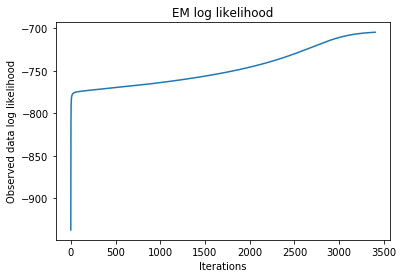

In [126]:
time = [i for i in range(len(em.obs_log_lik))]
plt.plot(time, em.obs_log_lik)
#plt.axhline(y=log_lik_true_param, color='r')
plt.xlabel('Iterations')
plt.ylabel('Observed data log likelihood')
plt.title('EM log likelihood')
plt.show()

In [127]:
def mapd(actual, pred):
    return np.average(np.abs((actual-pred)/actual)) * 100

print('estimated A: {}'.format(em.A))
print('true A: {}'.format(model.A))
print('mean absolute percentage difference of A: {}'.format(mapd(model.A, em.A)))
print('estimated b: {}'.format(em.b))
print('true b: {}'.format(model.b))
print('mean absolute percentage difference of b: {}'.format(mapd(model.b, em.b)))
print('estimated initial state mean: {}'.format(em.init_z))
print('true initial state mean: {}'.format(model.init_z))
print('mean absolute percentage difference of initial state mean: {}'.format(mapd(model.init_z, em.init_z)))
print('estimated sigma_0: {}'.format(em.sigma_0))
print('true sigma_0: {}'.format(model.noise_0))
print('mean absolute percentage difference of initial state variance: {}'.format(mapd(model.noise_0, em.sigma_0)))
print('estimated sigma_1: {}'.format(em.sigma_1))
print('true sigma_1: {}'.format(model.noise_1))
print('mean absolute percentage difference of transition variance: {}'.format(mapd(model.noise_1, em.sigma_1)))
print('estimated sigma_2: {}'.format(em.sigma_2))
print('true sigma_2: {}'.format(model.noise_2))
print('mean absolute percentage difference of observation variance: {}'.format(mapd(model.noise_2, em.sigma_2)))
print('estimated ratio: {}'.format(em.sigma_1/em.sigma_2))
print('true ratio: {}'.format(model.noise_1/model.noise_2))
print('intercept: {}'.format(em.intercept))

estimated A: [[0]]
true A: [[0]]
mean absolute percentage difference of A: nan
estimated b: [11.06445121]
true b: [10]
mean absolute percentage difference of b: 10.644512115719138
estimated initial state mean: 5.703091447243647
true initial state mean: 6
mean absolute percentage difference of initial state mean: 4.948475879272548
estimated sigma_0: 0.8855990499077244
true sigma_0: 1
mean absolute percentage difference of initial state variance: 11.440095009227559
estimated sigma_1: 0.8987150326975337
true sigma_1: 1
mean absolute percentage difference of transition variance: 10.128496730246628
estimated sigma_2: 0.0449707829958143
true sigma_2: 0.01
mean absolute percentage difference of observation variance: 349.70782995814295
estimated ratio: 19.98442039092765
true ratio: 100.0
intercept: [-0.42870207]


/home/bear/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


ValueError: x and y must have same first dimension, but have shapes (0,) and (66,)

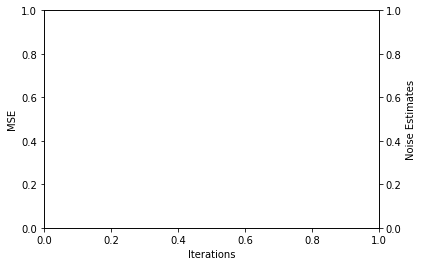

In [8]:
fig, ax1 = plt.subplots()
time = [i for i in range(len(em.mse))]
#ax1.plot(time, em.mse, label='MSE', color='r')
ax1.set_xlabel('Iterations')
ax1.set_ylabel('MSE')

ax2 = ax1.twinx()
ax2.set_ylabel('Noise Estimates')
ax2.plot(time, em.params[em.A.shape[1]+em.b.shape[0]+1], label='sigma 0')
ax2.axhline(y=model.noise_2, color='g', linestyle=':', label='true value')

plt.legend()
plt.show()

In [ ]:
fig, ax1 = plt.subplots()
time = [i for i in range(len(em.mse))]
ax1.plot(time, em.mse, label='MSE', color='r')
ax1.set_xlabel('Iterations')
ax1.set_ylabel('MSE')

ax2 = ax1.twinx()
ax2.set_ylabel('Coefficient Estimates')
color = ['m', 'y']
for i in range(em.A.shape[1]):
    ax2.plot(time, em.params[i], label='Coefficient A {}'.format(i+1))
    ax2.axhline(y=model.A[0, i], linestyle=':', label='true value coeffient A {}'.format(i+1), color=color[i])
for i in range(em.A.shape[1], em.A.shape[1]+em.b.shape[0]):
    ax2.plot(time, em.params[i], label='Coeffient b {}'.format(i+1-em.A.shape[1]))
    ax2.axhline(y=model.b[i-em.A.shape[1]], linestyle=':', label='true value coeffient b')
#for i in range(em.A.shape[1]+em.b.shape[0], len(em.params.keys())):
#    plt.plot(time,)
plt.legend()
plt.show()

In [ ]:
for n in range(10):
    plot(em, n, time_unit=1, true_model=True, model=model, signal_name='simulation', treatment_types=['1', '2'])

In [ ]:
fig, ax1 = plt.subplots()
time = [i for i in range(len(em.mse))]
ax1.plot(time, em.mse, label='MSE', color='r')
ax1.set_xlabel('Iterations')
ax1.set_ylabel('MSE')

ax2 = ax1.twinx()
ax2.set_ylabel('Noise Estimates')
ax2.plot(time, em.params[len(em.params.keys())-1], label='sigma 2')
ax2.axhline(y=model.noise_2, color='g', linestyle=':', label='true value')
plt.legend()
plt.show()

In [ ]:
fig, ax1 = plt.subplots()
time = [i for i in range(len(em.mse))]
ax1.plot(time, em.mse, label='MSE', color='r')
ax1.set_xlabel('Iterations')
ax1.set_ylabel('MSE')

ax2 = ax1.twinx()
ax2.set_ylabel('Noise Estimates')
ax2.plot(time, em.params[em.A.shape[1]+em.b.shape[0]+2], label='sigma 1')
ax2.axhline(y=model.noise_1, color='g', linestyle=':', label='true value')

plt.legend()
plt.show()

In [ ]:
fig, ax1 = plt.subplots()
time = [i for i in range(len(em.mse))]
ax1.plot(time, em.mse, label='MSE', color='r')
ax1.set_xlabel('Iterations')
ax1.set_ylabel('MSE')

ax2 = ax1.twinx()
ax2.set_ylabel('Initial state mean Estimates')
ax2.plot(time, em.params[em.A.shape[1]+em.b.shape[0]], label='initial state mean')
ax2.axhline(y=model.init_z, color='g', linestyle=':', label='true value')

plt.legend()
plt.show()

In [ ]:
em.obs_log_lik

In [ ]:
time = [i for i in range(len(em.expected_log_lik))]
plt.plot(time, em.expected_log_lik)
#plt.axhline(y=log_lik_true_param, color='r')
plt.xlabel('Iterations')
plt.ylabel('Expected data log likelihood')
plt.title('EM expected log likelihood')
plt.show()

In [ ]:
%%capture
# to debug loglik
for i in range(0):
    model = Model(20, 1, 0.3)
    model.run_simulation()
    em = EM(model.y, model.X, model.c, model.A.shape[0], 0, train_pct = 1, single_effect=False)
    num_iter = em.run_EM(5000)
    #loglik_increase = all([em.expected_log_lik[j] <= em.expected_log_lik[j+1] for j in range(len(em.expected_log_lik)-1)])
    loglik_increase = all([em.obs_log_lik[j] <= em.obs_log_lik[j+1] for j in range(len(em.obs_log_lik)-1)])
    if not loglik_increase:
        break

In [ ]:
i

In [ ]:
time = [i for i in range(len(em.obs_log_lik))]
plt.plot(time, em.obs_log_lik)
#plt.axhline(y=log_lik_true_param, color='r')
plt.xlabel('Iterations')
plt.ylabel('Observed data log likelihood')
plt.title('EM log likelihood')
plt.show()

In [ ]:
#measurements = ma.asarray(model.y)
#measurements[:, np.where(np.isnan(model.y[0, :]))[0]] = ma.masked
measurements = ma.asarray(model.y)
measurements[:, np.where(np.isnan(model.y[0, :]))[0]] = ma.masked

In [ ]:
from pykalman import KalmanFilter
X = np.transpose(measurements)
kf = KalmanFilter(transition_matrices = 1, observation_matrices = 1, initial_state_covariance=em.init_0, initial_state_mean=em.init_state, transition_covariance=em.init_1, observation_covariance=em.init_2)
kf = kf.em(X, n_iter=num_iter, em_vars=['initial_state_mean', 'initial_state_covariance', 'transition_covariance', 'observation_covariance'])

time = [i for i in range(len(kf.loglik))]
plt.plot(time, kf.loglik)
#plt.axhline(y=log_lik_true_param, color='r')
plt.xlabel('Iterations')
plt.ylabel('Observed data log likelihood')
plt.title('pykalman log likelihood')
plt.show()

In [ ]:
all([kf.loglik[j] <= kf.loglik[j+1] for j in range(len(kf.loglik)-1)])

In [ ]:
kf.initial_state_covariance[0][0]

In [ ]:
em.sigma_0

In [ ]:
kf.initial_state_mean[0]

In [ ]:
em.init_z

In [ ]:
kf.transition_covariance[0][0]

In [ ]:
em.sigma_1

In [ ]:
kf.observation_covariance[0][0]

In [ ]:
em.sigma_2

### Last Observation Carry Forward

In [ ]:
# assume the first observation is not nan and the data array is not entirely nan
def LBCF(data):
    filled = np.zeros(data.shape)
    for n in range(data.shape[0]):
        for i, y in enumerate(data[n, :]):
            if np.isnan(y):
                filled[n, i] = filled[n, i-1]
            else:
                filled[n, i] = y
    return filled

### Notes on the current model

1. Identifying coefficients is still somewhat challenging (often off by a little), especially when the noises are larger.
2. When the coefficients are too small i.e. closer to the noise value, the model is unable to recover them.
3. The model has trouble identifying the noise values.  

sigma_filter appears to converge to a value for all t > $t_0$. This replicates the updates equations, where y represents sigma_pred, x represents kgain, z represents sigma_filter. Following iterations, z always converges to one of the roots of the polynomial z^2 + a*z -a*b.